# Bantry Submission - R notebook

This notebook is arranged in the order of the presentation slides and is intended to be read along side it.

It provides code used to generate findings and plots.  It also goes further than what is presented, with additional plots and stats.

A couple of the plots in the presentation were generated using the data here but in Tableau.  The datasets are provided here.

If you have any questions - feel free to reach out to Ronen (ronenbecker@gmail.com)

#### Load Relevant Libaries

In [43]:
library(ggplot2)
library(dplyr)
library(gridExtra)
library(lubridate)
library(RColorBrewer)
library(reshape2)
library(tidyr)
library(ggcorrplot)
library(repr)
library(treemap)
  

-----

### Slide 4:

#### Slide4:  few details about our approach

In [44]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

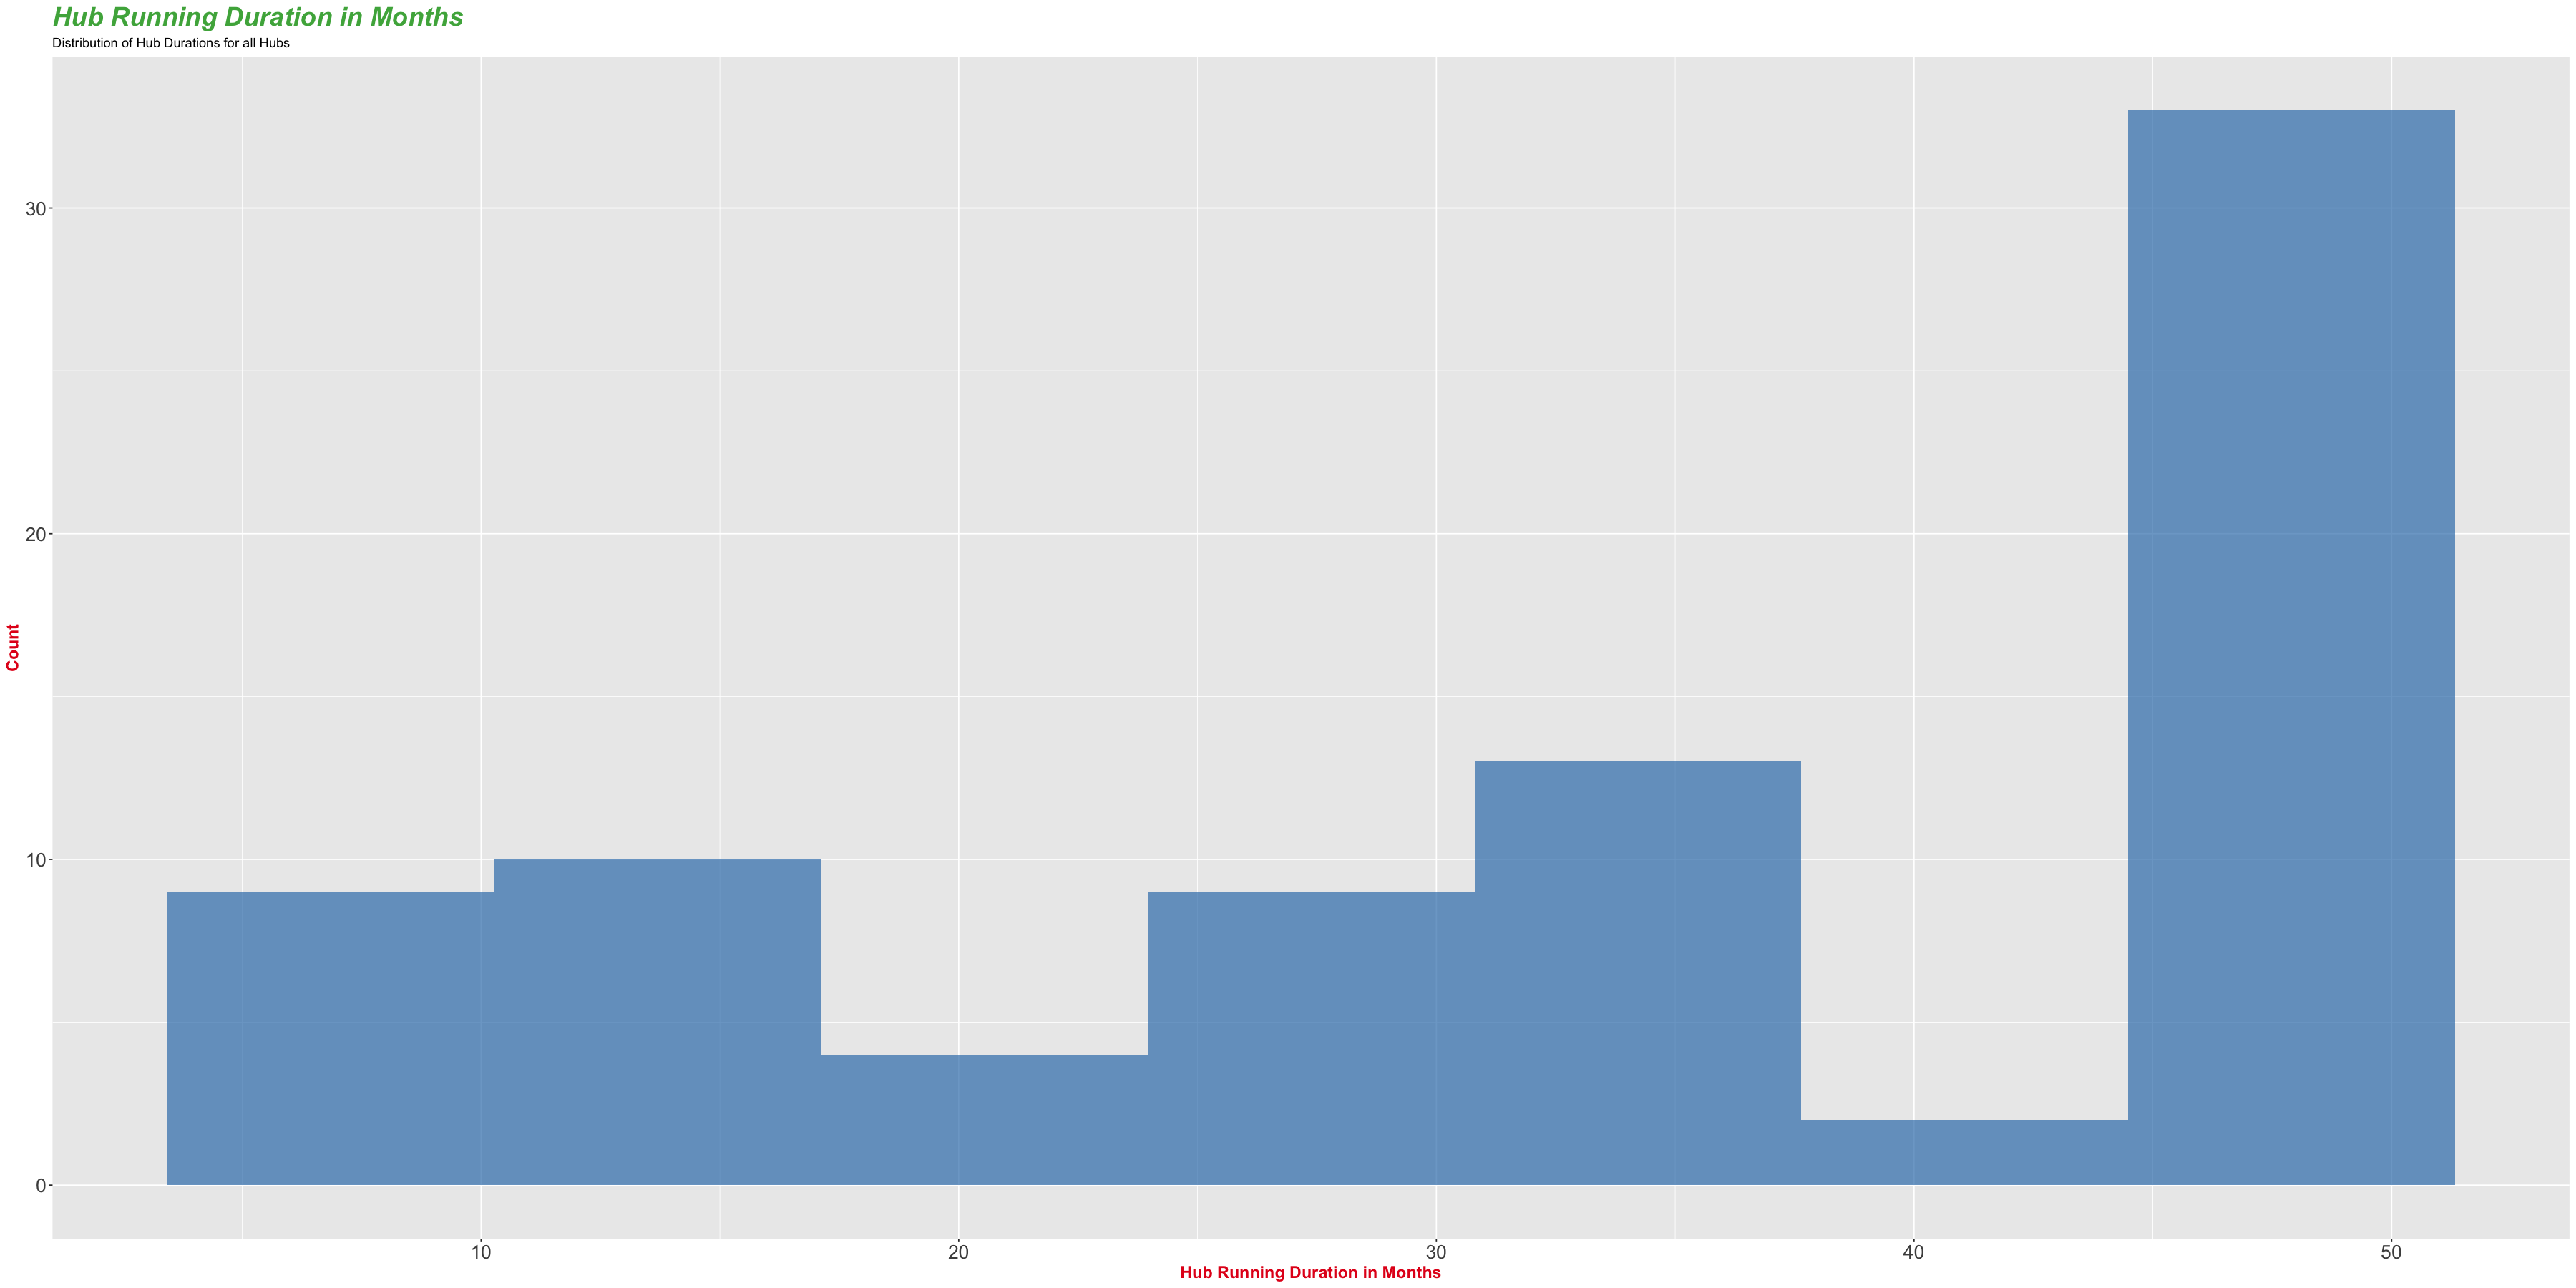

In [45]:
# How we analysed it slide
      # -----------------------------  #  Hub Perspective :
      ## Convert to date format
      Datathon$ActivityDate <- as.character(Datathon$ActivityDate)
      Datathon$ActivityDate<- dmy(Datathon$ActivityDate)
      
      #hub category aggregate Table
      hub_cat_agg <- Datathon %>% group_by(HubRandomID) %>%
        summarise(PA = sum(CategoryName == "Programmed Activities"),  
                  EAT = sum(CategoryName == "Education and Training"),
                  OOE = sum(CategoryName == "One Off events"),
                  SR =  sum(CategoryName == "Service Referrals"),
                  Min_DT = min(ActivityDate),
                  Max_DT = max(ActivityDate),
                  Duration = Max_DT - Min_DT,
                  duration_mnths = as.numeric((Duration/365))*12
        ) 
      
      #hub program (short name) aggregate Table
      
      hub_prog_agg <- Datathon %>% group_by(HubRandomID, ShortName ) %>% summarise(cnt = n())
      hub_prog_agg_corr <-  pivot_wider(hub_prog_agg ,names_from = ShortName, values_from = c(cnt), values_fill = list(cnt = 0))
      
      
      
      
      hub_cat_agg %>% ggplot(aes(x=duration_mnths)) + 
        xlab("Hub Running Duration in Months") +
        ylab("Count") +
        ggtitle("Hub Running Duration in Months", subtitle = "Distribution of Hub Durations for all Hubs") +
        geom_histogram(fill ="#377EB8", bins = 7, alpha = 0.7) +
        theme(
          plot.title = element_text(color="#4DAF4A", size=22, face="bold.italic"),
          axis.title.x = element_text(color="#E41A1C", size=14, face="bold"),
          axis.title.y = element_text(color="#E41A1C", size=14, face="bold"),
          axis.text=element_text(size=16)
        ) 


----

### Slide 8

#### Slide8:  Activities Across CHA

#### Data Prep:

- Get the data to be based on a per month basis to make each hub comparible given their different running times.
- Remove records that are not relevant to the analysis such as activities that ran with 0 attendees.  

In [46]:
# Load the Data
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [47]:
Datathon$ActivityDate <- as.character(Datathon$ActivityDate)
Datathon$ActivityDate<- dmy(Datathon$ActivityDate)

### Get a long table for all SRS for all Hubs
hub_pa_agg_mth <- Datathon %>% 
                    #### Remove all Activities with 0 attendees unless they are Service Referrals:
                    filter((CategoryName != "Service Referrals" & (ChildParticipants != 0 | AdultParticipants !=0 )) | CategoryName == "Service Referrals" ) %>%
                    #### Remove all SR with 'Number of Families Participating'
                    filter(ShortName != "Number of families participating in the Hub") %>% 
                    group_by(HubRandomID, CategoryName ) %>%
                    summarise(cnt = n())

# get min and max dates for each hub and join back to table
hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
                                                            max_dt = max(ActivityDate),
                                                            duration = max_dt - min_dt)

hub_pa_agg_mth <- hub_pa_agg_mth %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Join maxmin dates back to table:
hub_pa_agg_mth <- hub_pa_agg_mth %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth    # PAs per month                   
                       )

# Create a wide table useful for analysis 
hub_pa_agg_mth_wide <-  pivot_wider(hub_pa_agg_mth ,names_from = CategoryName, values_from = c(cnt, avg_cnt_mnth), values_fill = list(cnt = 0, avg_cnt_mnth =0)) 

### Rename columns:
hub_pa_agg_mth_wide <- hub_pa_agg_mth_wide %>% rename(
                                                      cnt_EAT = "cnt_Education and Training",
                                                      cnt_OOE = "cnt_One Off events",
                                                      cnt_PA = "cnt_Programmed Activities",
                                                      cnt_SR = "cnt_Service Referrals",
                                                      # avg_cnt_mth
                                                      avg_cnt_mth_EAT = "avg_cnt_mnth_Education and Training",
                                                      avg_cnt_mth_OOE = "avg_cnt_mnth_One Off events",
                                                      avg_cnt_mth_PA = "avg_cnt_mnth_Programmed Activities",
                                                      avg_cnt_mth_SR = "avg_cnt_mnth_Service Referrals"
                                                    ) #For renaming tibble column using dplyrpipe
                                           #operator

### Calculate create feature as proportion of month:
hub_pa_agg_mth_wide <- hub_pa_agg_mth_wide %>% mutate( total_avg_cnt_mth = avg_cnt_mth_EAT+avg_cnt_mth_OOE+avg_cnt_mth_PA+avg_cnt_mth_SR,
                                PA_avg_prop = avg_cnt_mth_PA / total_avg_cnt_mth,
                                EAT_avg_prop = avg_cnt_mth_EAT/ total_avg_cnt_mth,
                                OOE_avg_prop = avg_cnt_mth_OOE/ total_avg_cnt_mth,
                                SR_avg_prop = avg_cnt_mth_SR/ total_avg_cnt_mth,
                                SR_PA_ratio = avg_cnt_mth_SR/avg_cnt_mth_PA)

#### Slide8:  What is the breakdown of each activity by category type:
- This section compares hubs by examining  
    - a. The average number of activities run each month by category as an average of all hubs.
    - b. The proportion of activities run each month broken down by category types as an average of all hubs.

#### Slide8: Average Activity Cat Count per Month (Left Bubble Chart):

In [48]:
hub_pa_agg_mth_wide %>% ungroup() %>% summarise(mean_OOE = mean(avg_cnt_mth_OOE),
                                                mean_PA = mean(avg_cnt_mth_PA),
                                                mean_SR = mean(avg_cnt_mth_SR),
                                                mean_EAT = mean(avg_cnt_mth_EAT)                                               
                           ) 

mean_OOE    mean_PA  mean_SR  mean_EAT
1 0.005928136 18.80505 17.20191 3.660151

__Approach__:
 - We take the mean of the all the hubs average cnt per month of each activity category

__Observations__:
 - We can see that on monthly average hubs
  - run approx 19 PA 
  - make approx 18 Service Referrals 
  - Run 3 EAT activities

#### Slide 8:  Proportion of Activities Per Month by Cat Proportions (Right Bubble Chart):

In [49]:
hub_pa_agg_mth_wide %>% ungroup() %>% summarise(mean_OOE = mean(OOE_avg_prop),
                                                mean_PA = mean(PA_avg_prop),
                                                mean_SR = mean(SR_avg_prop),
                                                mean_EAT = mean(EAT_avg_prop)                                               
                           ) 

mean_OOE     mean_PA   mean_SR   mean_EAT  
1 0.0001941134 0.4810234 0.4276403 0.09114217

__Approach__:
- Initially we look at the activities based on their categories. 
- Taking the average number of each activity based on their category for each month that a hub was running
- We then look at it as a proportion of all other category activities for that month (out of OOE, PA, SR, EAT)
- We calculated these for each hub
- We then took the mean ofthese proportions of all hubs to come up with the values above.
- These tells the typical proportions of each activity based on category.

__Observations:__
- They tells us that PAs and SR categories make up most of the activites each month.
- Because these were averages other metrics they will not add up to 1.
- The plot below depcits the individual breakdowns of these for each hub.


-------

### Slide 9

#### Slide 9: Visualising the proportions of each category activity for all hubs:

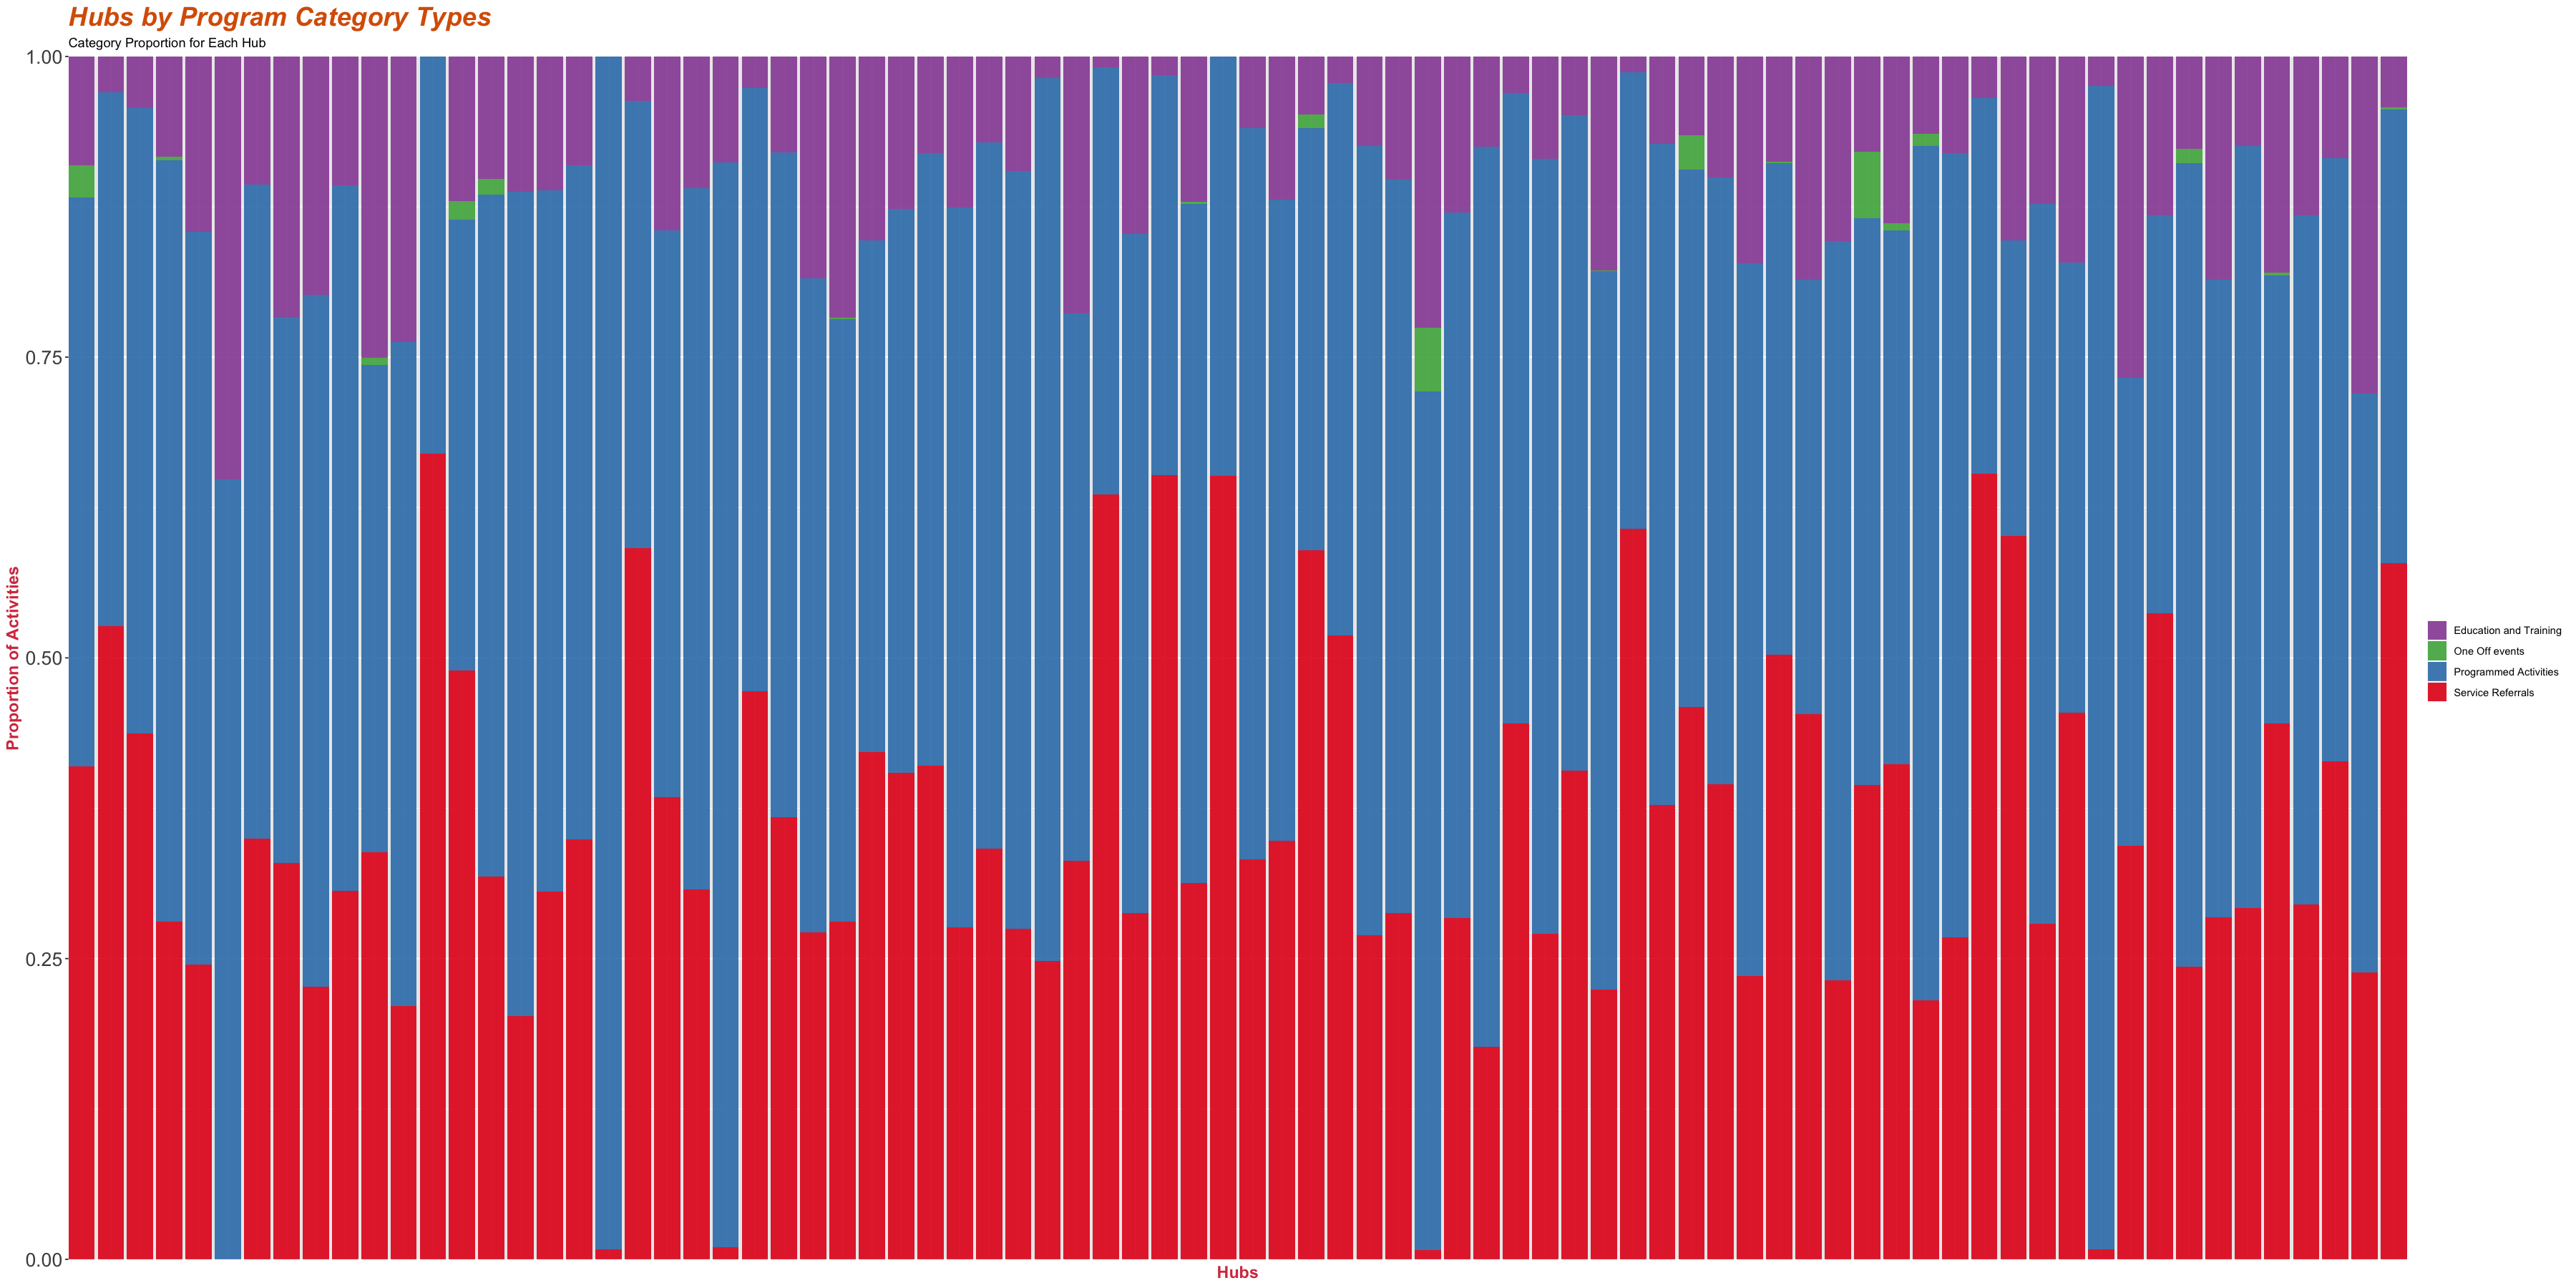

In [50]:
  hub_cat_agg %>% select("HubRandomID", "Programmed Activities" = "PA","Education and Training" = "EAT","One Off events"= "OOE","Service Referrals" ="SR" ) %>%
          pivot_longer(cols = c(-HubRandomID), names_to = "Category")  %>%     # put all colums other than HubRandomID into Category
          ggplot(aes(x= factor(HubRandomID), y = value ,fill = factor(Category) )) +
          ggtitle("Hubs by Program Category Types", subtitle = "Category Proportion for Each Hub") +
          geom_bar(position = "fill", stat="identity" , alpha = 0.9 ) +
          theme(axis.text.x=element_blank(), 
                axis.ticks.x=element_blank(), 
                legend.title =element_blank(),
                plot.title = element_text(color="#D95F02", size=22, face="bold.italic"),
                axis.title.x = element_text(color="#D53E4F", size=14, face="bold"),
                axis.title.y = element_text(color="#D53E4F", size=14, face="bold"),
                axis.text=element_text(size=16)
                ) +
          scale_x_discrete(expand = c(0,0)) +
          scale_y_continuous(expand = c(0,0)) +
          ylab ("Proportion of Activities")  +
          xlab ("Hubs") +
          scale_fill_brewer(palette = "Set1", type = "div", direction = -1)
options(repr.plot.width=30, repr.plot.height=15)

__Observations:__
* It is clear that some hubs are not making any service referrals
* It is also clear that some hubs are making disproportionate service referrals
* __EAT and OOE make up a very small proportion of activities.  Given this, our analysis will focus only on PA and SRs__
    

-----

### Slide 10

#### Slide 10A: Distribution of average number of PA per hub per month (refers to first sentence):

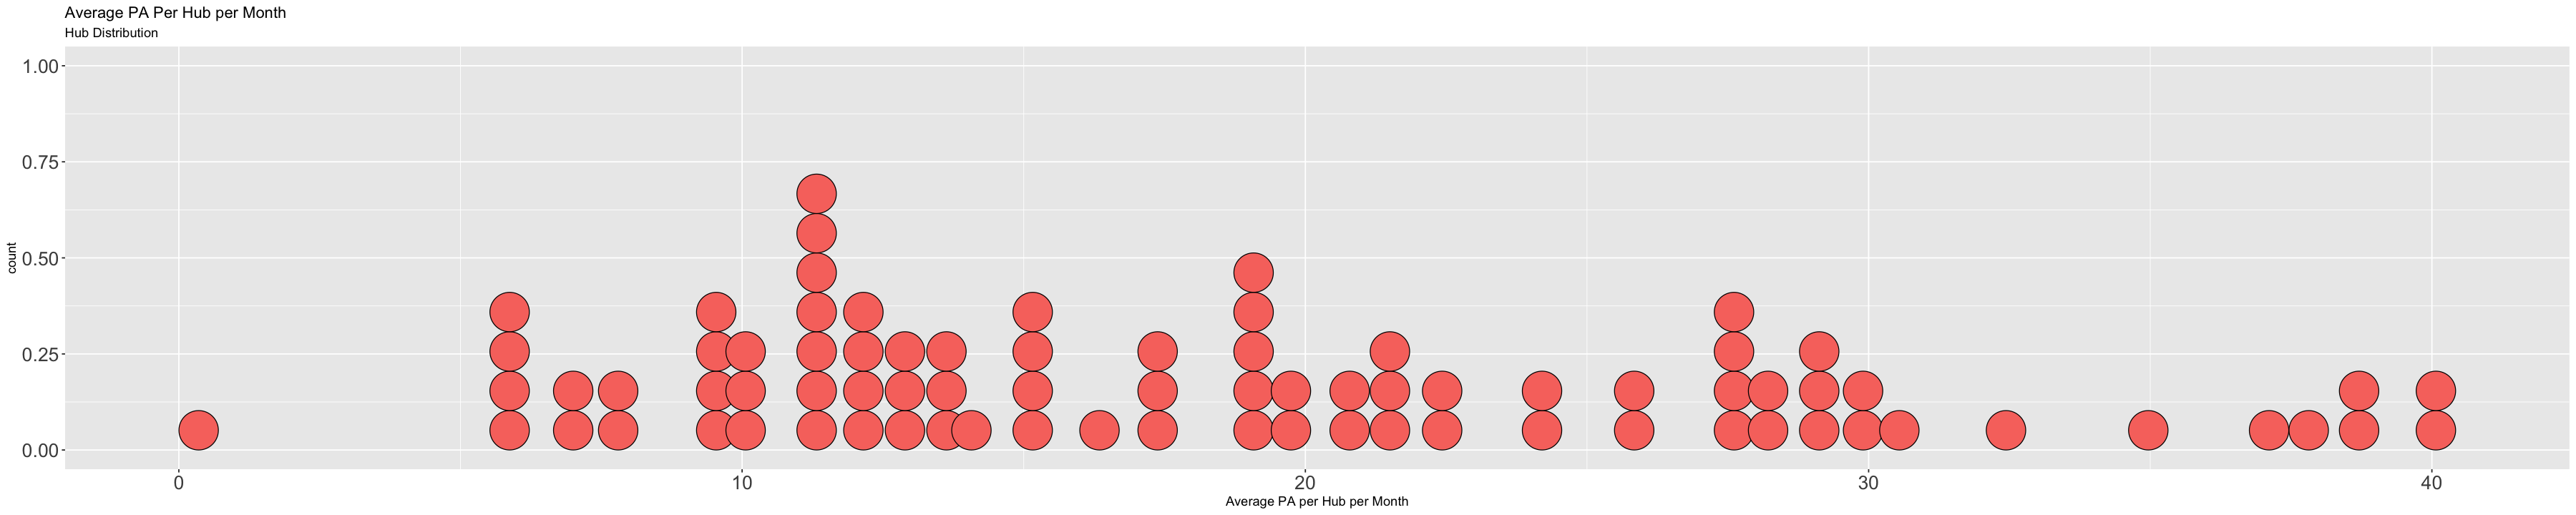

In [52]:
hub_pa_agg_mth %>% filter(CategoryName == "Programmed Activities")  %>% 
ggplot(aes(x=avg_cnt_mnth)) +
xlab("Average PA per Hub per Month") +
ggtitle("Average PA Per Hub per Month", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.7, aes(fill = "light green") )+
theme(legend.position = "none",
     axis.text=element_text(size=16)
     ) 
options(repr.plot.width=30, repr.plot.height=6)

In [53]:
hub_pa_agg_mth %>% ungroup() %>% filter(CategoryName == "Programmed Activities")  %>% 
 summarise(min = min(avg_cnt_mnth),
                          q1 = quantile(avg_cnt_mnth,0.25),
                          mean = mean(avg_cnt_mnth),
                          median = median(avg_cnt_mnth),
                          q3 = quantile(avg_cnt_mnth,0.75),
                          max = max(avg_cnt_mnth),
                          sd = sd(avg_cnt_mnth),
                          IQR = IQR(avg_cnt_mnth),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) 

min       q1       mean     median   q3       max      sd      IQR     
1 0.3516378 11.47655 18.80505 17.34314 26.30497 40.32881 9.53438 14.82842
  LowOutlier HighOutliet latest_open_dt latest_activity_dt
1 -10.76608  48.5476     2019-06-28     2019-12-20

__Approach__:

- We take the average PA that each hub runs a month

__Observations__:
- Typically, each hub runs about 19 Program Activities per month
- There are a number of hubs who run less than 10.  Although these are not outliers - one may want to investigate these, as these numbers are quite low.

In [14]:
hub_pa_agg_mth %>% ungroup() %>% filter(CategoryName == "Programmed Activities")  %>% filter (avg_cnt_mnth <= 10) %>% arrange(avg_cnt_mnth)

HubRandomID CategoryName          cnt min_dt     max_dt     duration 
1  10932       Programmed Activities   2 2019-06-28 2019-12-18  173 days
2  18200       Programmed Activities 194 2017-01-23 2019-12-11 1052 days
3  18812       Programmed Activities 254 2016-04-25 2019-12-06 1320 days
4  12756       Programmed Activities 208 2017-01-23 2019-12-10 1051 days
5  12736       Programmed Activities 139 2018-01-29 2019-12-19  689 days
6  12420       Programmed Activities  72 2019-01-29 2019-12-19  324 days
7  11662       Programmed Activities 251 2017-01-23 2019-12-13 1054 days
8  16724       Programmed Activities 294 2016-02-01 2019-04-08 1162 days
9  10011       Programmed Activities 251 2017-04-17 2019-12-09  966 days
10 17604       Programmed Activities 291 2017-04-17 2019-12-05  962 days
11 13876       Programmed Activities 331 2017-01-23 2019-12-13 1054 days
12 13958       Programmed Activities 309 2017-04-17 2019-12-12  969 days
13 11419       Programmed Activities 458 2016-02-01 2019-12-12 1410 days
14 15301       Programmed Activities  73 2019-05-03 2019-12-12  223 days
   duration_mnth avg_cnt_mnth
1   5.687671     0.3516378   
2  34.586301     5.6091572   
3  43.397260     5.8529040   
4  34.553425     6.0196638   
5  22.652055     6.1363087   
6  10.652055     6.7592593   
7  34.652055     7.2434377   
8  38.202740     7.6957831   
9  31.758904     7.9032954   
10 31.627397     9.2008836   
11 34.652055     9.5521031   
12 31.857534     9.6994324   
13 46.356164     9.8800236   
14  7.331507     9.9570254

#### Slide 10B: Distribution of average number of PA per hub per month for each PA type (Plot)

This sections is a more detailed look at the above, looking at the average per month based on PA types.

In [54]:
### Get a long table for all SRS for all Hubs

hub_pa_agg <- Datathon %>% filter(CategoryName == "Programmed Activities" & (ChildParticipants != 0 | AdultParticipants !=0 )) %>% group_by(HubRandomID, ShortName ) %>% summarise(
    cnt = n(),
    cnt_child = sum(ChildParticipants),
    cnt_adult = sum(AdultParticipants),
    avg_cnt_pa = ((cnt_child + cnt_adult) / cnt), # avg attendance per session
    avg_child_pa = cnt_child/cnt, # average child attendance per session
    avg_adult_pa = cnt_adult/cnt) # average adult attendance per session

# get min and max dates for each hub and join back to table
#hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
#                                                            max_dt = max(ActivityDate),
#                                                            duration = max_dt - min_dt
#                                                           ) 
# Join maxmin dates back to table:
hub_pa_agg <- hub_pa_agg %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Develop new metrics - avg per month:
hub_pa_agg <- hub_pa_agg %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth                      
                       )
# Develop wide table with column for each SR based on avg cnt per month
hub_pa_agg_wide <- hub_pa_agg %>% select(HubRandomID, ShortName, min_dt, max_dt, duration_mnth,avg_cnt_mnth ) %>% pivot_wider(names_from = ShortName, values_from = c(avg_cnt_mnth), values_fill = list(cnt = 0))   



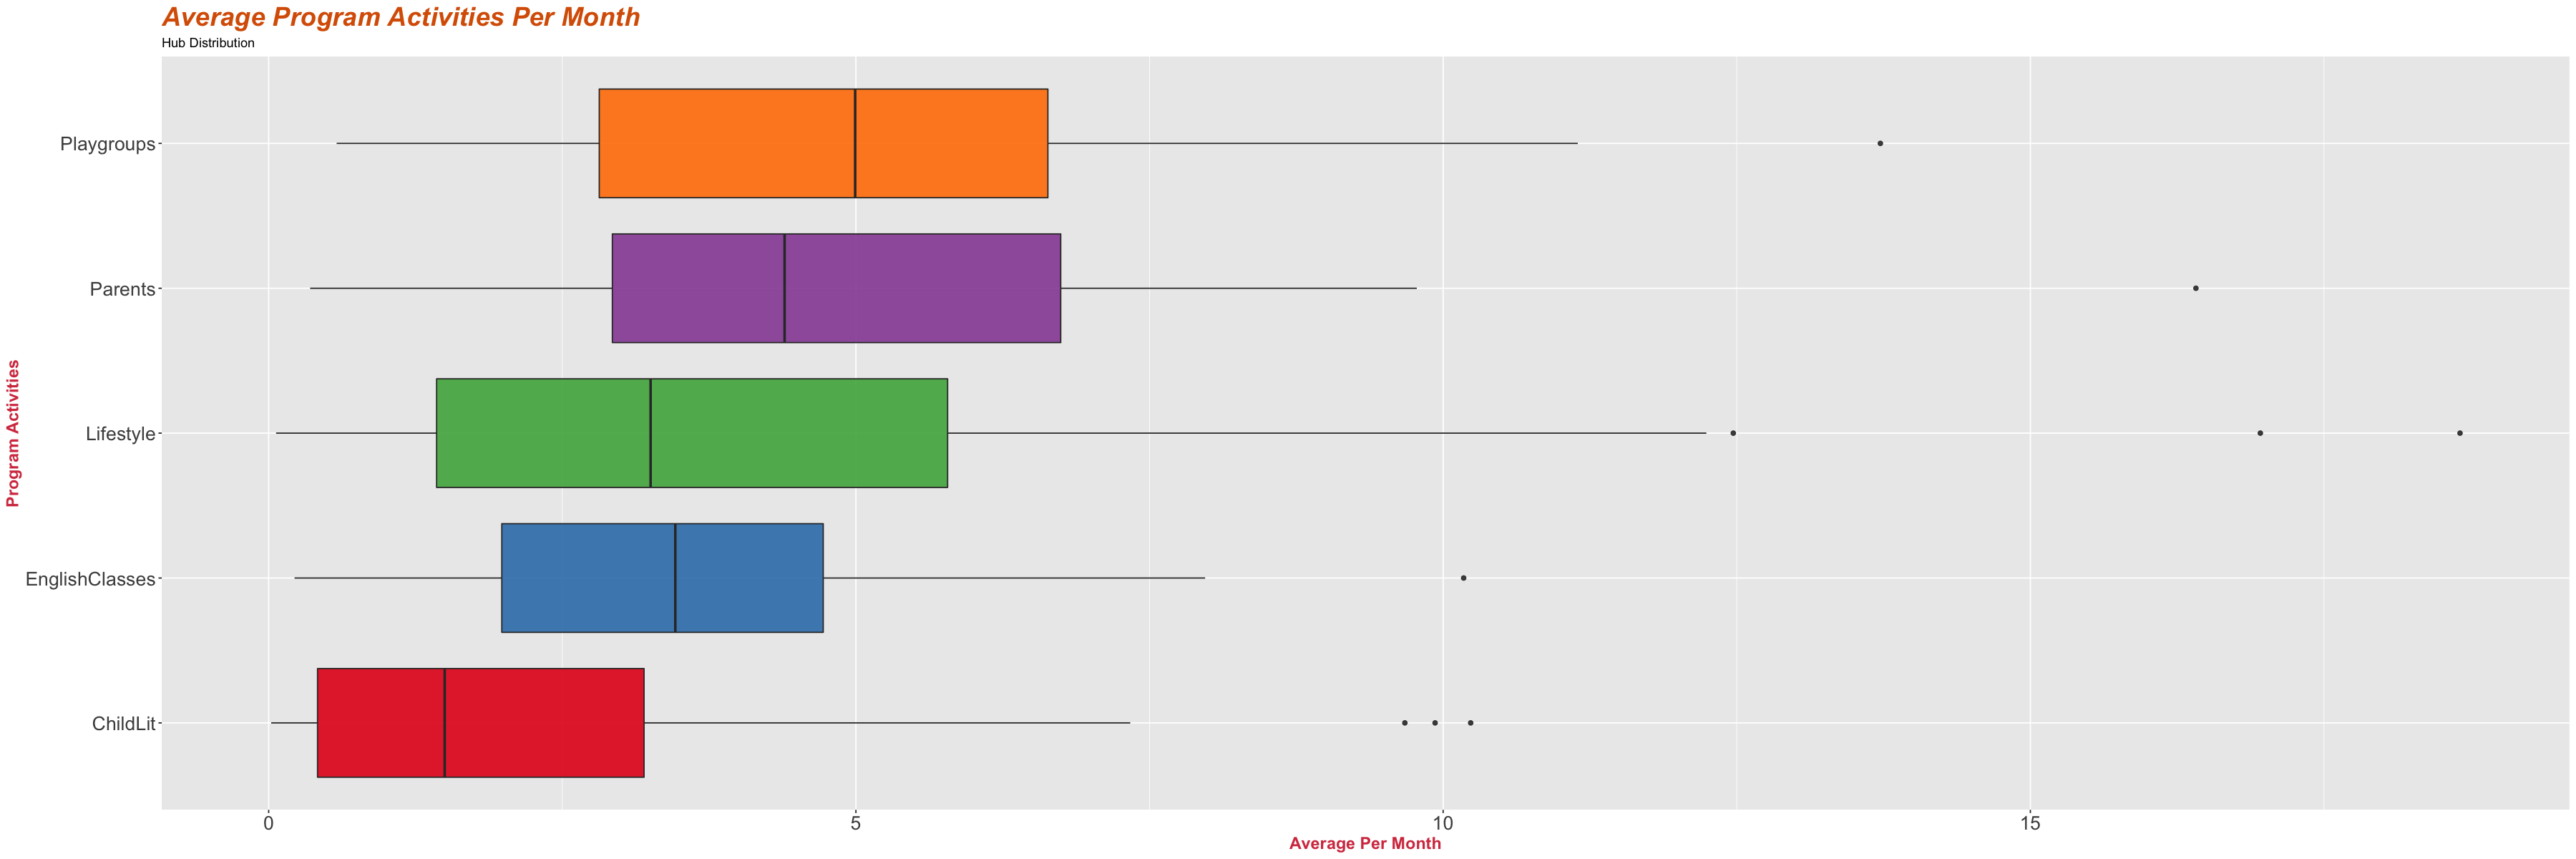

In [56]:
   hub_pa_agg %>% ggplot(aes( x= factor(ShortName), y=avg_cnt_mnth, fill = factor(ShortName))) + 
      coord_flip()  +
      theme(legend.position = "none") +
      xlab("Program Activities") +
      ylab("Average Per Month") +
      ggtitle("Average Program Activities Per Month", subtitle = "Hub Distribution") +
      #theme(axis.title.x=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
      theme(
           # axis.title.x=element_blank(), 
            #axis.text.y=element_blank(), 
            #axis.ticks.y=element_blank(),
            legend.title =element_blank(),
            plot.title = element_text(color="#D95F02", size=22, face="bold.italic"),
            axis.title.x = element_text(color="#D53E4F", size=14, face="bold"),
            axis.title.y = element_text(color="#D53E4F", size=14, face="bold"),
            axis.text=element_text(size=16)
      ) +
      #scale_x_discrete(expand = c(0,0)) +
      #scale_y_discrete(expand = c(0,0)) +
      scale_fill_brewer(palette = "Set1", type = "div", direction = 1) +
      geom_boxplot(alpha =0.9)    
    options(repr.plot.width=30, repr.plot.height=10)
    

#### Slide 10: Alternate Plots:

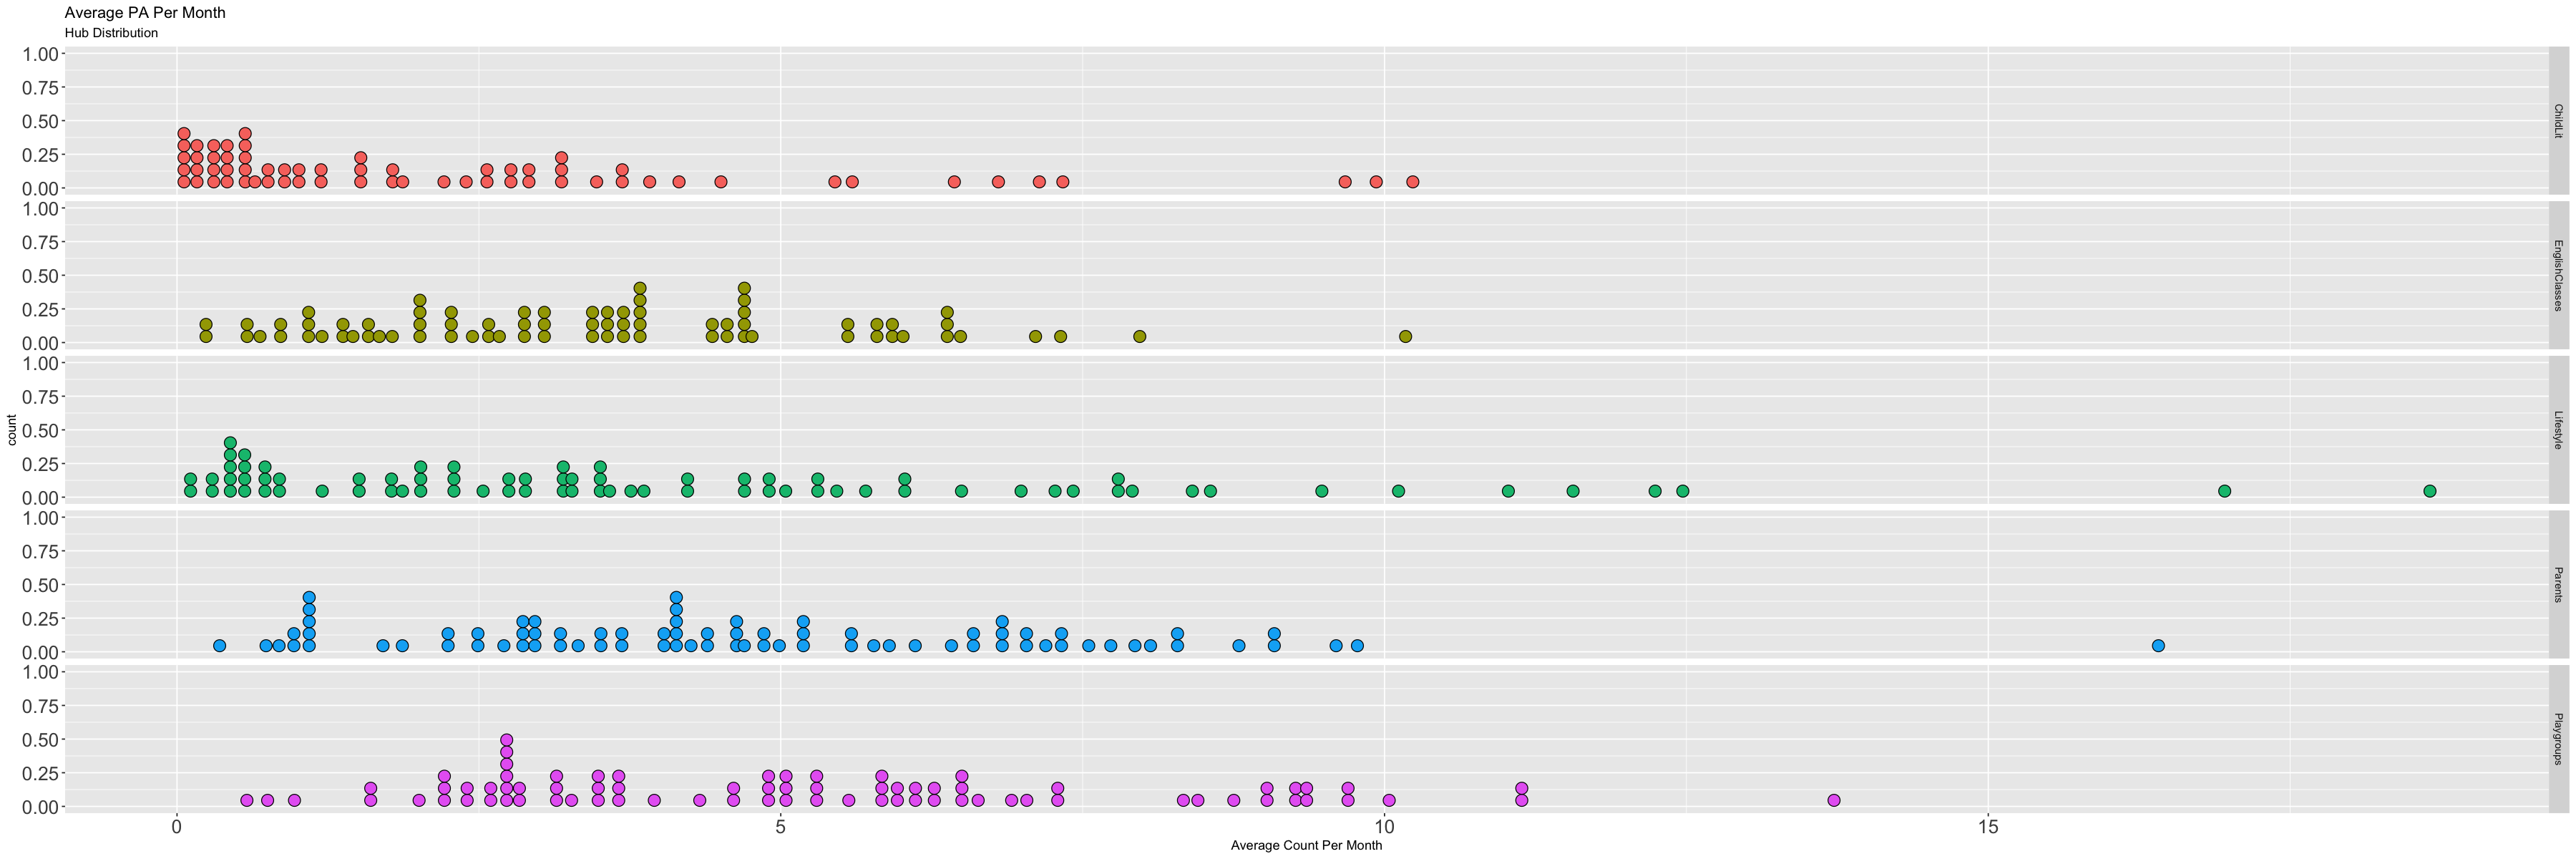

In [18]:
hub_pa_agg  %>% 
ggplot(aes(x=avg_cnt_mnth)) +
xlab("Average Count Per Month") +
ggtitle("Average PA Per Month", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.1, aes(fill =factor(ShortName)) )+
facet_grid(rows = vars(ShortName)) +
theme(legend.position = "none",
     axis.text=element_text(size=16)
     ) 
options(repr.plot.width= 30, repr.plot.height=12)

#### Slide 10: Stats

In [19]:
hub_pa_stats<-  hub_pa_agg %>% group_by(ShortName) %>% summarise(min = min(avg_cnt_mnth),
                          q1 = quantile(avg_cnt_mnth,0.25),
                          mean = mean(avg_cnt_mnth),
                          median = median(avg_cnt_mnth),
                          q3 = quantile(avg_cnt_mnth,0.75),
                          max = max(avg_cnt_mnth),
                          sd = sd(avg_cnt_mnth),
                          IQR = IQR(avg_cnt_mnth),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) %>% arrange(desc(IQR))
hub_pa_stats

ShortName      min        q1        mean     median   q3       max     
1 Lifestyle      0.06297447 1.4299615 4.224110 3.252060 5.780932 18.65815
2 Playgroups     0.57881383 2.8147624 5.250403 4.993781 6.634797 13.72287
3 Parents        0.35316884 2.9263098 4.779168 4.392782 6.744005 16.40956
4 ChildLit       0.02155682 0.4159881 2.343793 1.498792 3.196259 10.23445
5 EnglishClasses 0.22041063 1.9849338 3.495356 3.462396 4.721889 10.17474
  sd       IQR      latest_open_dt latest_activity_dt LowOutlier HighOutliet
1 3.868796 4.350970 2019-05-03     2019-12-20         -5.096494  12.307387  
2 2.810207 3.820035 2019-05-03     2019-12-20         -2.915290  12.364849  
3 2.760517 3.817695 2019-05-03     2019-12-20         -2.800233  12.470547  
4 2.573860 2.780271 2019-06-28     2019-12-20         -3.754418   7.366665  
5 2.044493 2.736955 2019-05-03     2019-12-20         -2.120499   8.827321

__Note:__ For these plots we excluded PA without attendees
- On average there are  5 Playgroups and Parents program activities run a month
- On average there are  4 lifestyle program activities run a month
- On average there are  3.4 english classes program activities run a month
- On average there are  2.3 Child Lit program activities run a month

__There a some outlier hubs who run more than what is typical a month:__


In [20]:
hub_pa_agg %>% filter(
                      (ShortName %in% c("Lifestyle","Playgroups", "Parents" ) & avg_cnt_mnth> 12 ) |
                      (ShortName == "ChildLit" & avg_cnt_mnth >7.3) |
                      (ShortName == "EnglishClasses" & avg_cnt_mnth > 8.8)
                     ) %>% arrange(ShortName)

HubRandomID ShortName      cnt cnt_child cnt_adult avg_cnt_pa avg_child_pa
1  11491       ChildLit       451  6881      1507      18.59867   15.257206  
2  14082       ChildLit       342  2508      1357      11.30117    7.333333  
3  14457       ChildLit       463  6138      1082      15.59395   13.257019  
4  18922       ChildLit       357  9790      2055      33.17927   27.422969  
5  15994       EnglishClasses 473  2214      4214      13.58985    4.680761  
6  10833       Lifestyle      583 23776      6639      52.16981   40.782161  
7  15669       Lifestyle      192  5562      1753      38.09896   28.968750  
8  18922       Lifestyle      427 67902      1378     162.24824  159.021077  
9  19483       Lifestyle      785 39575      5196      57.03312   50.414013  
10 13590       Parents        765 12013     14932      35.22222   15.703268  
11 11833       Playgroups     194  2046      1160      16.52577   10.546392  
   avg_adult_pa min_dt     max_dt     duration  duration_mnth avg_cnt_mnth
1   3.341463    2016-02-01 2019-12-20 1418 days 46.61918       9.674130   
2   3.967836    2016-02-01 2019-12-20 1418 days 46.61918       7.336037   
3   2.336933    2016-02-01 2019-12-20 1418 days 46.61918       9.931535   
4   5.756303    2017-01-23 2019-12-20 1061 days 34.88219      10.234449   
5   8.909091    2016-02-01 2019-12-16 1414 days 46.48767      10.174741   
6  11.387650    2016-01-27 2019-12-19 1422 days 46.75068      12.470406   
7   9.130208    2016-01-27 2016-12-05  313 days 10.29041      18.658147   
8   3.227166    2017-01-23 2019-12-20 1061 days 34.88219      12.241203   
9   6.619108    2016-01-27 2019-12-05 1408 days 46.29041      16.958156   
10 19.518954    2016-02-01 2019-12-20 1418 days 46.61918      16.409556   
11  5.979381    2018-10-15 2019-12-19  430 days 14.13699      13.722868

-----

### Slide 11

#### Slide 11: Average attendance per PA for each hub

In [57]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [58]:
### Get a long table for all PAs for all Hubs
hub_agg <- Datathon %>% filter(CategoryName == "Programmed Activities"  & (ChildParticipants != 0 | AdultParticipants !=0 ))%>% group_by(HubRandomID) %>% summarise(
    cnt = n(),
    cnt_child = sum(ChildParticipants),
    cnt_adult = sum(AdultParticipants),
    avg_cnt = ((cnt_child + cnt_adult) / cnt), # avg attendance per session
    avg_child = cnt_child/cnt, # average child attendance per session
    avg_adult = cnt_adult/cnt) # average adult attendance per session

# get min and max dates for each hub and join back to table
#hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
#                                                            max_dt = max(ActivityDate),
#                                                            duration = max_dt - min_dt
#                                                           ) 
# Join maxmin dates back to table:
hub_agg <- hub_agg %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Develop new metrics - avg per month:
hub_agg <- hub_agg %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth                      
                       )
# Develop wide table with column for each SR based on avg cnt per month
#hub_agg_wide <- hub_agg %>% select(HubRandomID, min_dt, max_dt, duration_mnth,avg_cnt_mnth ) %>% pivot_wider(names_from = ShortName, values_from = c(avg_cnt_mnth), values_fill = list(cnt = 0))   

Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”


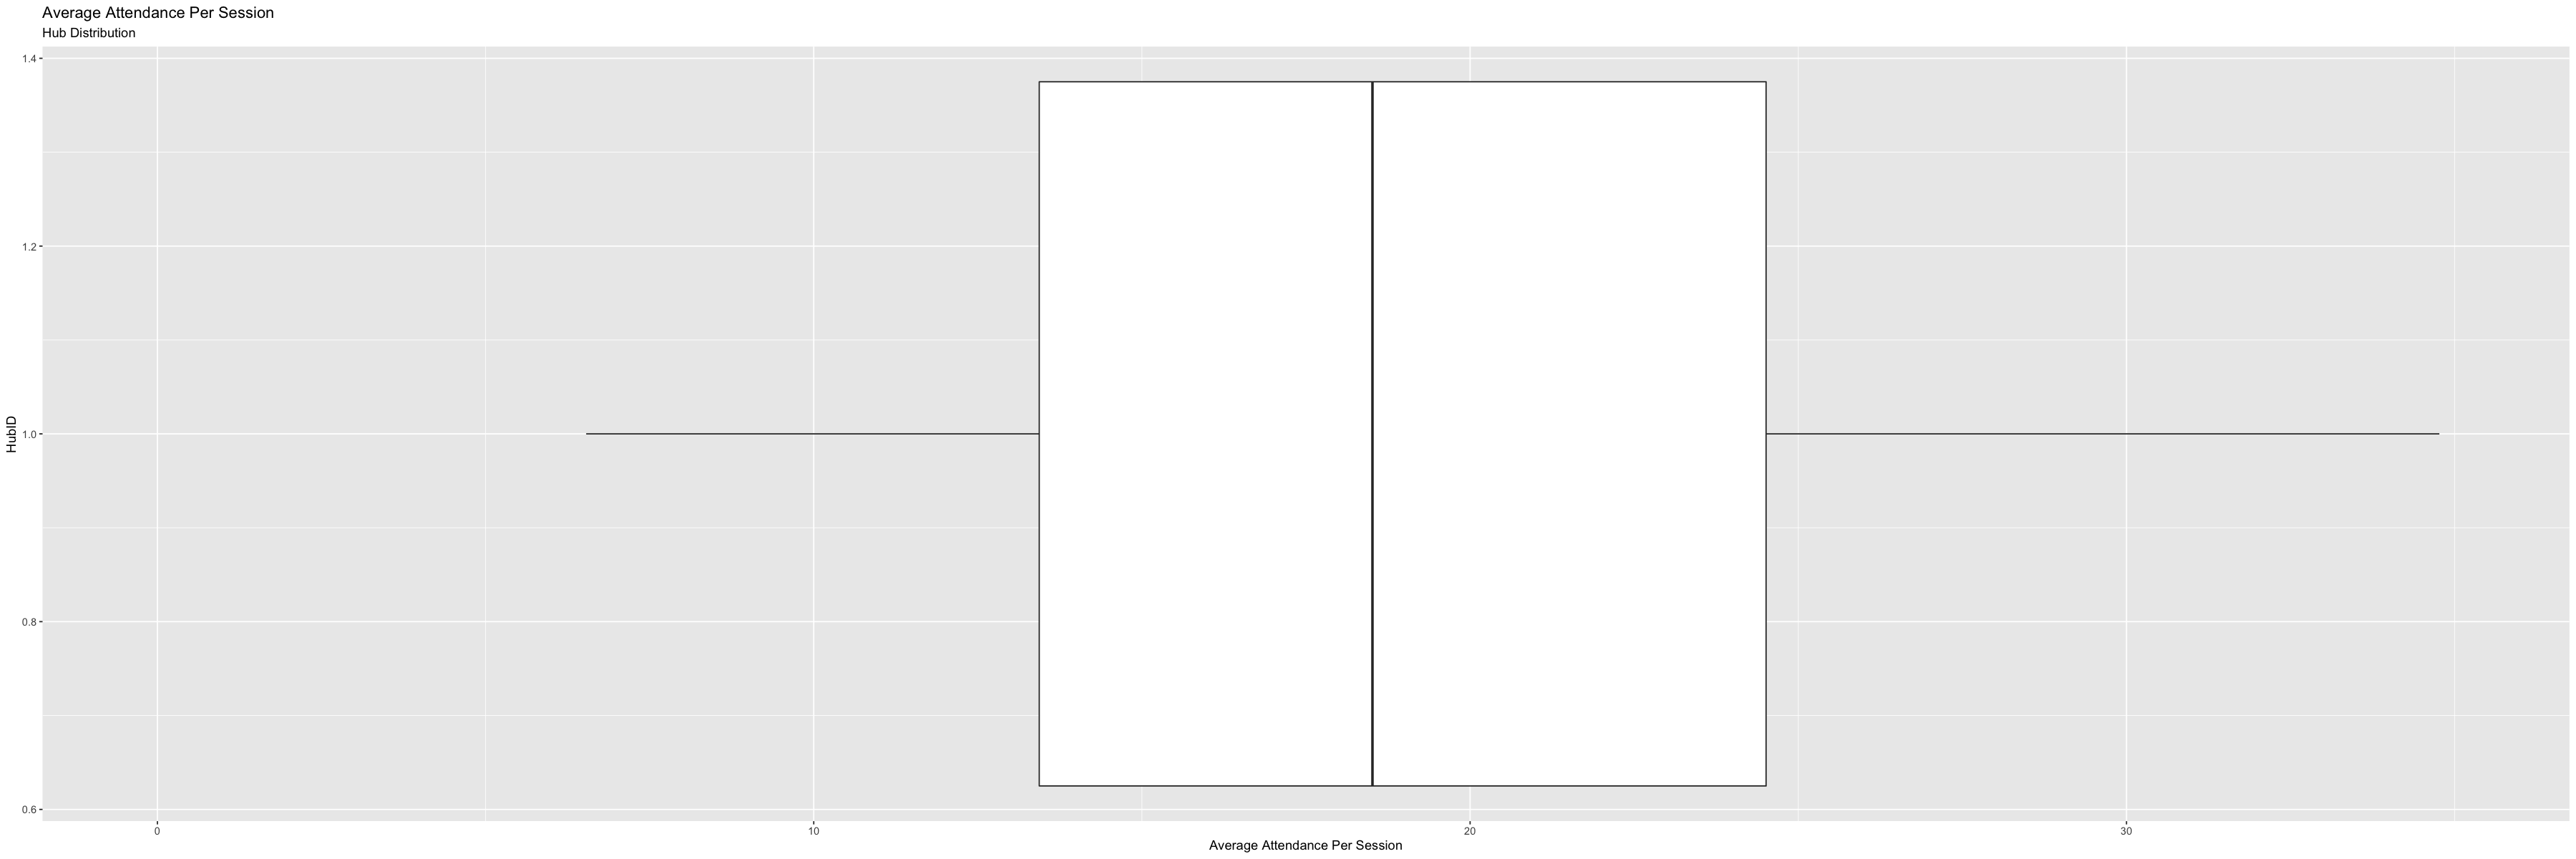

In [59]:
hub_agg  %>% ggplot(aes( x= 1, y=avg_cnt)) + 
  coord_flip()  +
  theme(legend.position = "none") +
  xlab("HubID") +
  ylab("Average Attendance Per Session") +
  ggtitle("Average Attendance Per Session", subtitle = "Hub Distribution") +
   ylim(0, 35) +
  #theme(axis.title.x=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
  geom_boxplot()

options(repr.plot.width=30, repr.plot.height=5)

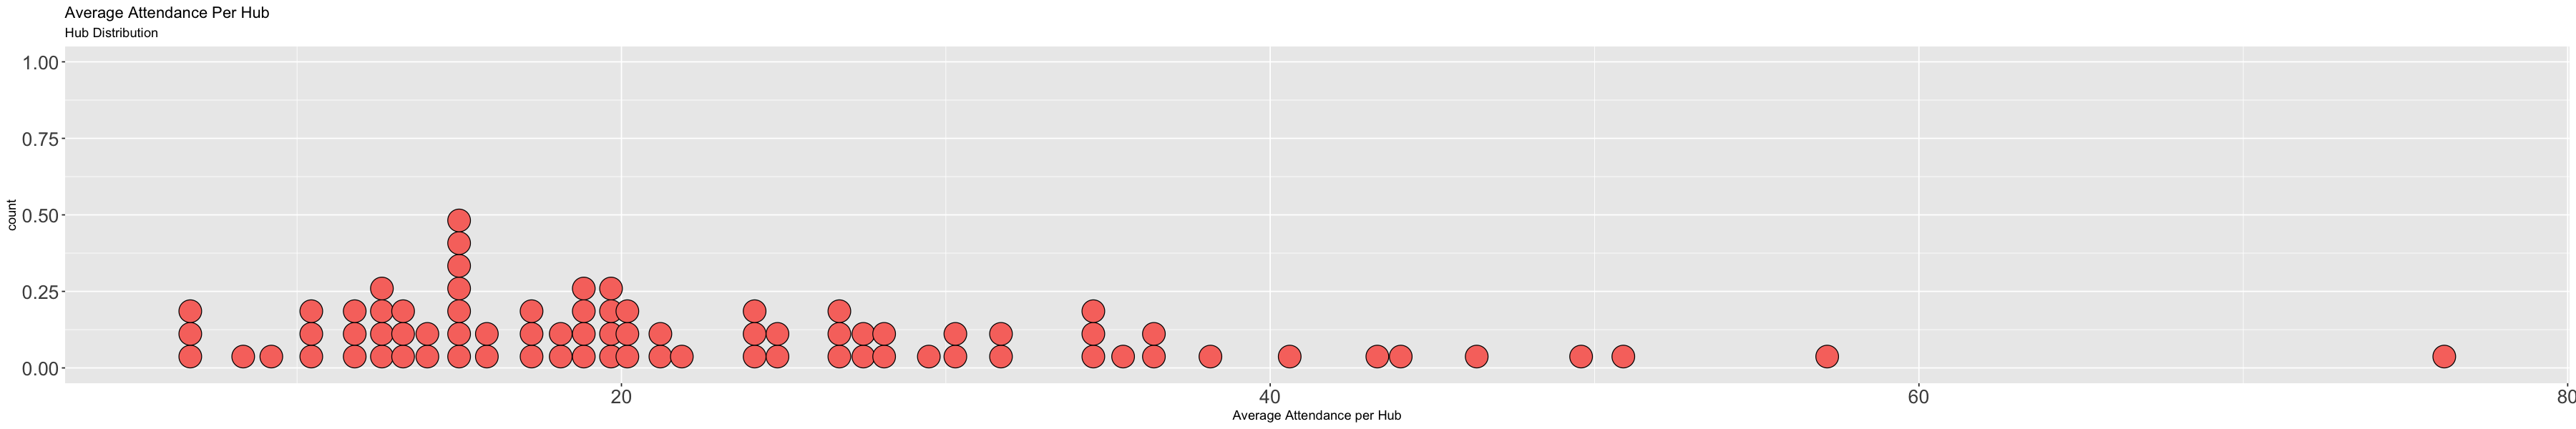

In [25]:
hub_agg  %>% 
ggplot(aes(x=avg_cnt)) +
xlab("Average Attendance per Hub") +
ggtitle("Average Attendance Per Hub", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.7, aes(fill = "light green") )+
theme(legend.position = "none",
     axis.text=element_text(size=16)
     ) 
options(repr.plot.width=30, repr.plot.height=6)

In [26]:
hub_agg_stats<-  hub_agg %>% summarise(min = min(avg_cnt),
                          q1 = quantile(avg_cnt,0.25),
                          mean = mean(avg_cnt),
                          median = median(avg_cnt),
                          q3 = quantile(avg_cnt,0.75),
                          max = max(avg_cnt),
                          sd = sd(avg_cnt),
                          IQR = IQR(avg_cnt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) 
hub_agg_stats

min      q1       mean     median   q3      max     sd       IQR     
1 6.532609 14.52955 23.13217 19.68407 28.4707 76.1956 12.61372 13.94115
  LowOutlier HighOutliet latest_open_dt latest_activity_dt
1 -6.382178  49.38243    2019-06-28     2019-12-20

- When we exclude PA with 0 attendees, the mean attendance per PA is 23.
- Maybe its worth examining hubs with sub 10 attendees on average per session
- The upper outlier is approximately 50.
    - There are 3 hubs who average 50 or more attendees per session. Perhaps these hubs are overcrowded?
 

In [60]:
hub_agg %>% filter(avg_cnt >= 50)

HubRandomID cnt  cnt_child cnt_adult avg_cnt  avg_child avg_adult min_dt    
1 12369       1324 52732     14642     50.88671 39.82779  11.058912 2016-02-01
2 17604        291  7102      9535     57.17182 24.40550  32.766323 2017-04-17
3 18922       1319 89159     11343     76.19560 67.59591   8.599697 2017-01-23
  max_dt     duration  duration_mnth avg_cnt_mnth
1 2019-12-20 1418 days 46.61918      28.400329   
2 2019-12-05  962 days 31.62740       9.200884   
3 2019-12-20 1061 days 34.88219      37.812991

- To see the list of hubs in order of attendance rates:

#### Slide 11: Average child attendance per PA for each hub:

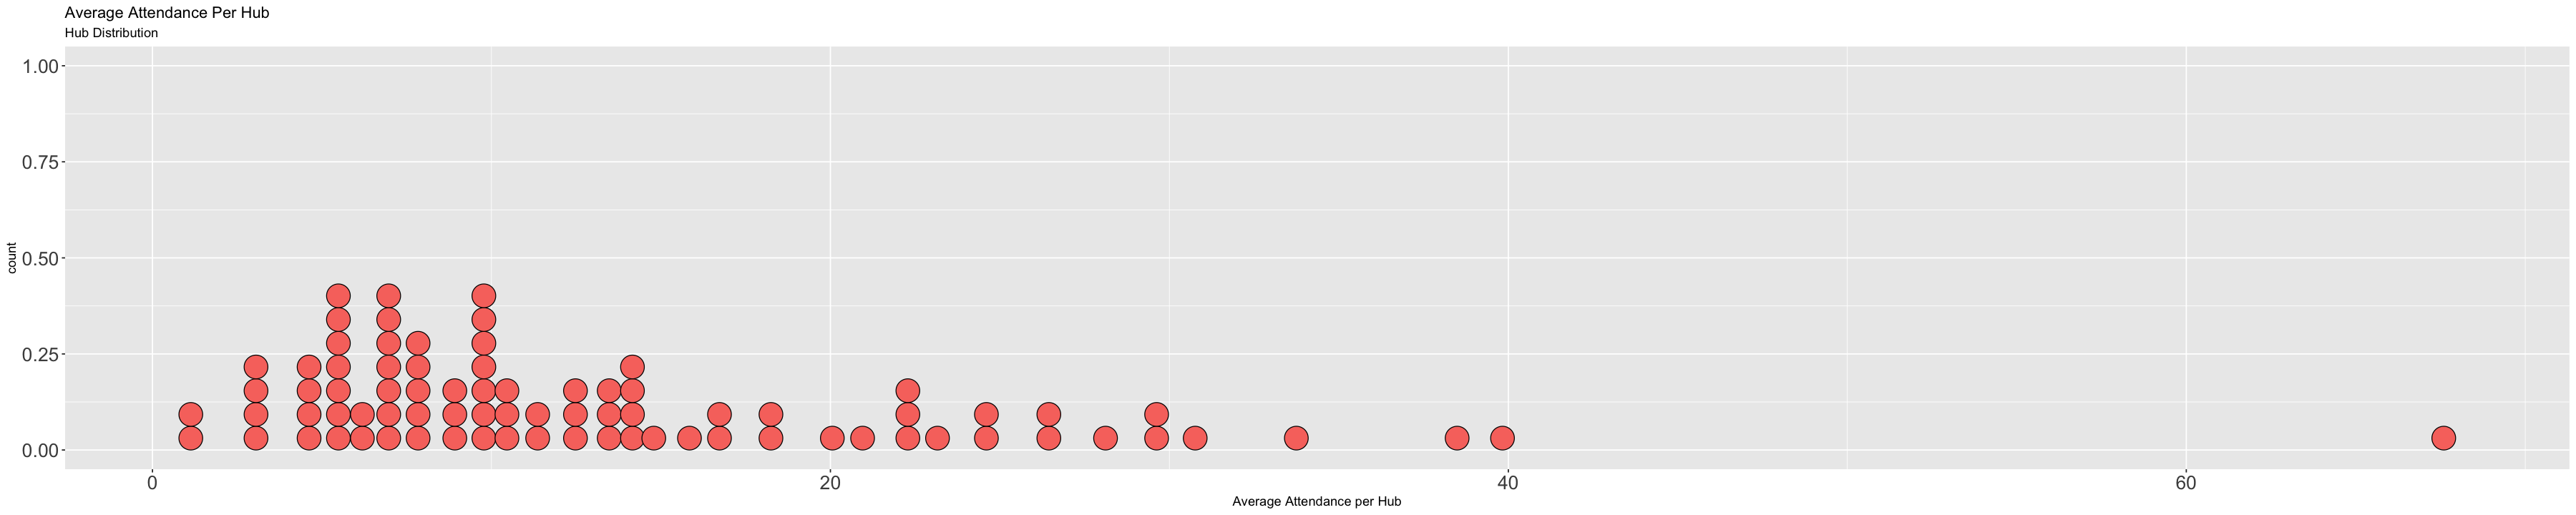

In [323]:
hub_agg  %>% 
ggplot(aes(x=avg_child)) +
xlab("Average Attendance per Hub") +
ggtitle("Average Attendance Per Hub", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.7, aes(fill = "light green") )+
theme(legend.position = "none",
     axis.text=element_text(size=16)
     ) 
options(repr.plot.width=30, repr.plot.height=6)

In [324]:
hub_agg_stats<-  hub_agg %>% summarise(min = min(avg_child),
                          q1 = quantile(avg_child,0.25),
                          mean = mean(avg_child),
                          median = median(avg_child),
                          q3 = quantile(avg_child,0.75),
                          max = max(avg_child),
                          sd = sd(avg_child),
                          IQR = IQR(avg_child),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) 
hub_agg_stats

min       q1       mean     median   q3       max      sd       IQR     
1 0.8152174 6.850677 13.59425 10.05574 17.15916 67.59591 10.68776 10.30848
  LowOutlier HighOutliet latest_open_dt latest_activity_dt
1 -8.612044  32.62188    2019-06-28     2019-12-20

- When we exclude PA with 0 attendees, the mean child attendance per PA is 13.
- Maybe its worth examining hubs with sub 5 attendees on average per session
- The upper outlier is approximately 32 children per session.
    - There are 4 hubs who average 32 or more attendees per session


In [61]:
hub_agg %>% filter(avg_child >= 32)

HubRandomID cnt  cnt_child cnt_adult avg_cnt  avg_child avg_adult min_dt    
1 12369       1324 52732     14642     50.88671 39.82779  11.058912 2016-02-01
2 13024        887 34140      9842     49.58512 38.48929  11.095829 2016-02-01
3 18922       1319 89159     11343     76.19560 67.59591   8.599697 2017-01-23
4 19483       1843 62193     23261     46.36679 33.74552  12.621270 2016-01-27
  max_dt     duration  duration_mnth avg_cnt_mnth
1 2019-12-20 1418 days 46.61918      28.40033    
2 2019-12-09 1407 days 46.25753      19.17525    
3 2019-12-20 1061 days 34.88219      37.81299    
4 2019-12-05 1408 days 46.29041      39.81386

#### Slide 11: Average adult attendance per PA for each hub:

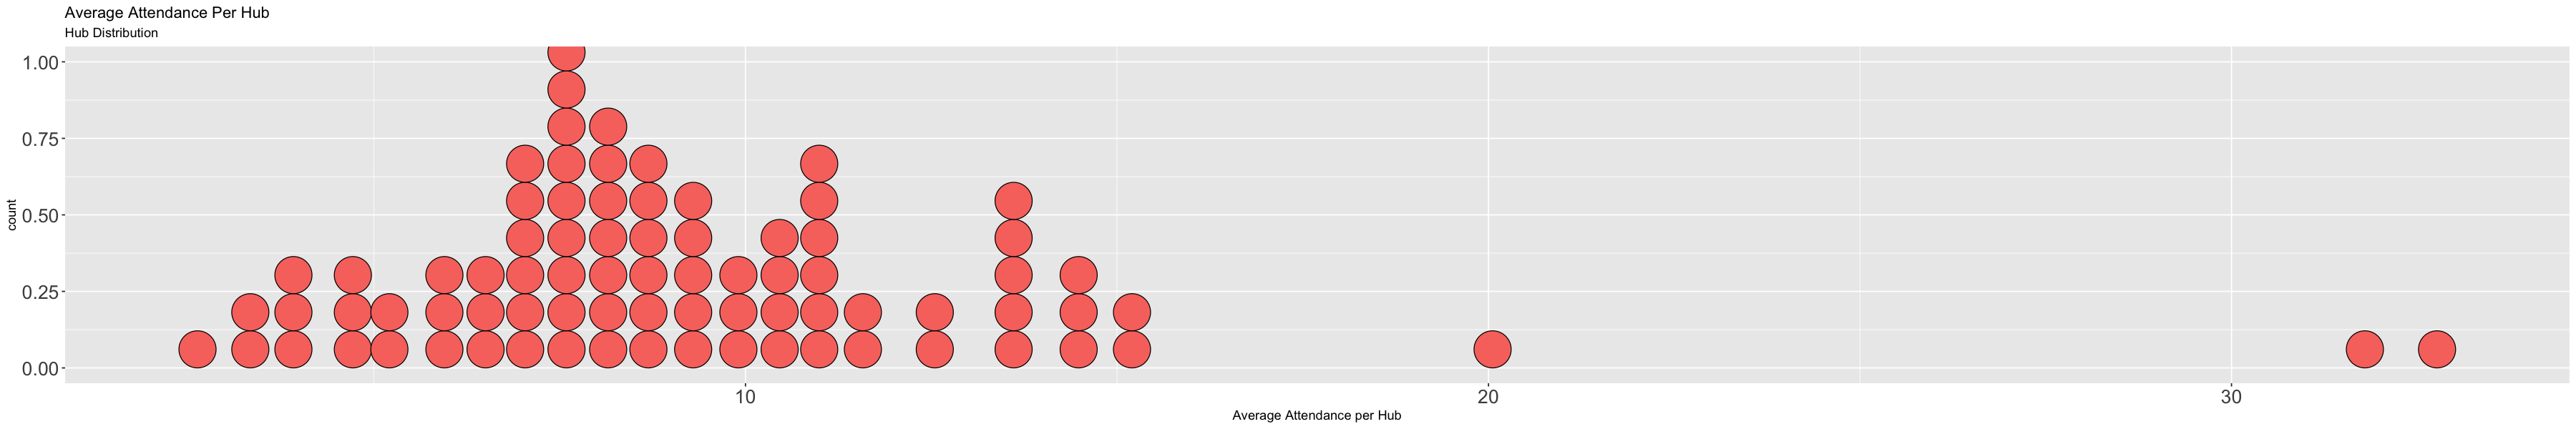

In [62]:
hub_agg  %>% 
ggplot(aes(x=avg_adult)) +
xlab("Average Attendance per Hub") +
ggtitle("Average Attendance Per Hub", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.5, aes(fill = "light green") )+
theme(legend.position = "none",
     axis.text=element_text(size=16)
     ) 
options(repr.plot.width=30, repr.plot.height=6)

In [327]:
hub_agg_stats<-  hub_agg %>% summarise(min = min(avg_adult),
                          q1 = quantile(avg_adult,0.25),
                          mean = mean(avg_adult),
                          median = median(avg_adult),
                          q3 = quantile(avg_adult,0.75),
                          max = max(avg_adult),
                          sd = sd(avg_adult),
                          IQR = IQR(avg_adult),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) 
hub_agg_stats

min   q1       mean     median   q3       max      sd       IQR     
1 2.625 7.199648 9.537918 8.546072 10.99349 32.76632 4.898432 3.793837
  LowOutlier HighOutliet latest_open_dt latest_activity_dt
1 1.508893   16.68424    2019-06-28     2019-12-20

- When we exclude PA with 0 attendees, the mean adult attendance per PA is 9 which lower than the child attendance of 13.
- The upper outlier is approximately 16 adults per session.
    - There are 3 hubs who average 16 or more attendees per session.  
    - Some of these are more than double and triple the mean. So worth investigating


In [63]:
hub_agg %>% filter(avg_adult >= 16)

HubRandomID cnt cnt_child cnt_adult avg_cnt  avg_child avg_adult min_dt    
1 11188       762  4848     24228     38.15748  6.362205 31.79528  2016-02-01
2 16538       996 14368     19975     34.48092 14.425703 20.05522  2016-02-01
3 17604       291  7102      9535     57.17182 24.405498 32.76632  2017-04-17
  max_dt     duration  duration_mnth avg_cnt_mnth
1 2019-12-20 1418 days 46.61918      16.345205   
2 2019-12-18 1416 days 46.55342      21.394774   
3 2019-12-05  962 days 31.62740       9.200884

#### Slide 11: Average attendance for each PA Types (Bottom Tree Map) 

In [64]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [10]:
### Get a long table for all SRS for all Hubs
hub_pa_agg <- Datathon %>% filter(CategoryName == "Programmed Activities"  & (ChildParticipants != 0 | AdultParticipants !=0 )) %>% group_by(HubRandomID, ShortName ) %>% summarise(
    cnt = n(),
    cnt_child = sum(ChildParticipants),
    cnt_adult = sum(AdultParticipants),
    avg_cnt_pa = ((cnt_child + cnt_adult) / cnt), # avg attendance per session
    avg_child_pa = cnt_child/cnt, # average child attendance per session
    avg_adult_pa = cnt_adult/cnt) # average adult attendance per session
    
# get min and max dates for each hub and join back to table
#hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
#                                                            max_dt = max(ActivityDate),
#                                                            duration = max_dt - min_dt
#                                                           ) 
# Join maxmin dates back to table:
hub_pa_agg <- hub_pa_agg %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Develop new metrics - avg per month:
hub_pa_agg <- hub_pa_agg %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth                      
                       )
# Develop wide table with column for each SR based on avg cnt per month
hub_pa_agg_wide <- hub_pa_agg %>% select(HubRandomID, ShortName, min_dt, max_dt, duration_mnth,avg_cnt_mnth ) %>% pivot_wider(names_from = ShortName, values_from = c(avg_cnt_mnth), values_fill = list(cnt = 0))   

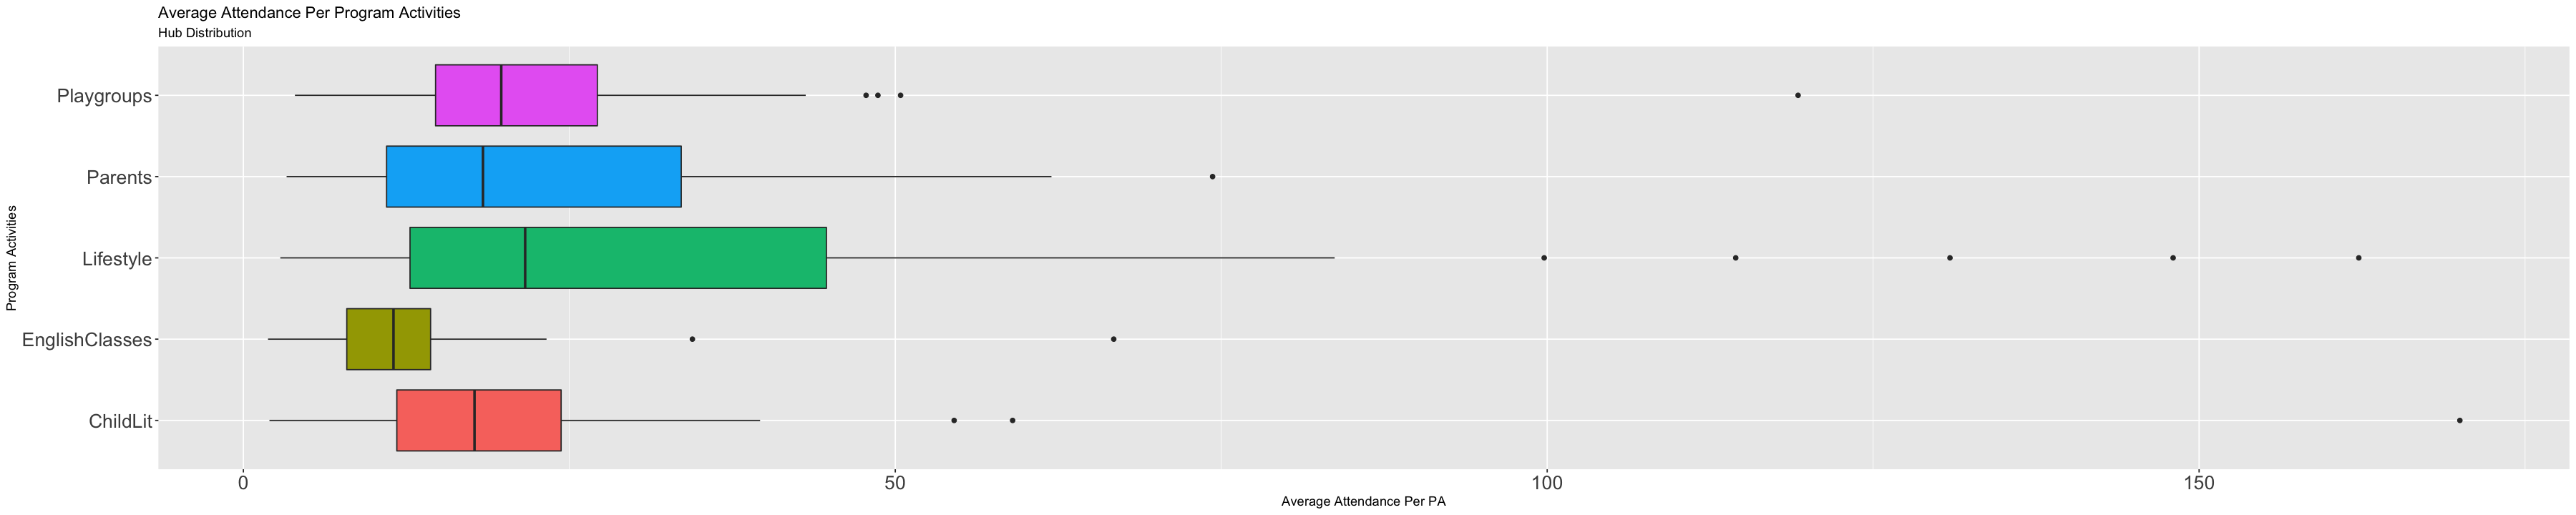

In [65]:
hub_pa_agg %>% ggplot(aes( x= factor(ShortName), y=avg_cnt_pa, fill = factor(ShortName))) + 
  coord_flip()  +
  theme(legend.position = "none") +
  xlab("Program Activities") +
  ylab("Average Attendance Per PA") +
  ggtitle("Average Attendance Per Program Activities", subtitle = "Hub Distribution") +
theme(axis.text=element_text(size=16)) +
  #theme(axis.title.x=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
  geom_boxplot() 
 options(repr.plot.width=30, repr.plot.height=15)

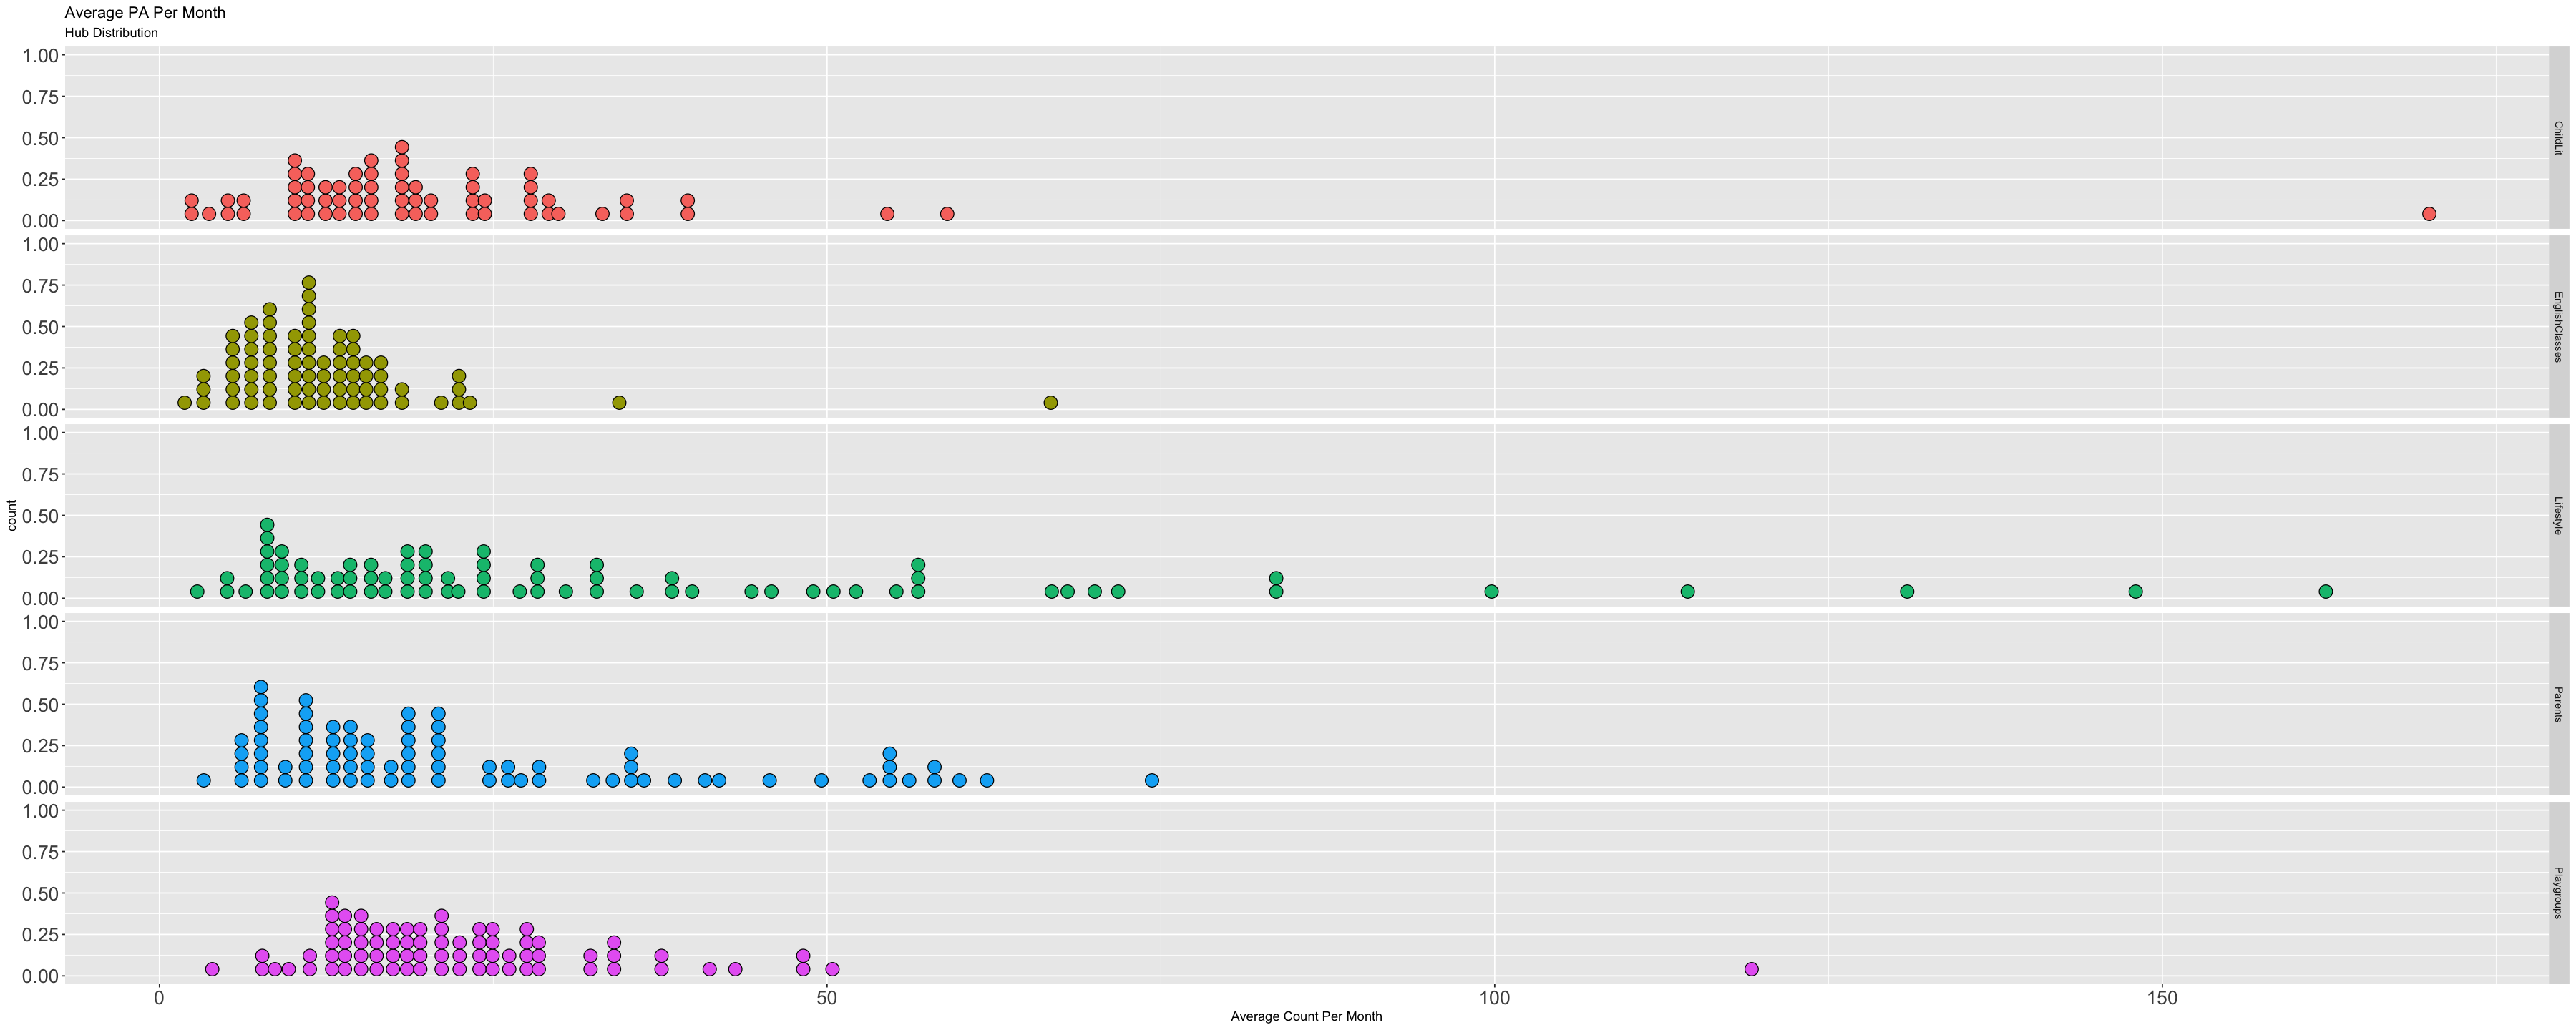

In [67]:
hub_pa_agg  %>% 
ggplot(aes(x=avg_cnt_pa)) +
xlab("Average Count Per Month") +
ggtitle("Average PA Per Month", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 1, aes(fill =factor(ShortName)) )+
facet_grid(rows = vars(ShortName)) +
theme(legend.position = "none",
     axis.text=element_text(size=16)
     ) 
options(repr.plot.width= 30, repr.plot.height=12)

In [68]:
hub_pa_stats<-  hub_pa_agg %>% group_by(ShortName) %>% summarise(min = min(avg_cnt_pa),
                          q1 = quantile(avg_cnt_pa,0.25),
                          mean = mean(avg_cnt_pa),
                          median = median(avg_cnt_pa),
                          q3 = quantile(avg_cnt_pa,0.75),
                          max = max(avg_cnt_pa),
                          sd = sd(avg_cnt_pa),
                          IQR = IQR(avg_cnt_pa),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) %>% arrange(desc(mean))
hub_pa_stats

ShortName      min      q1        mean     median   q3       max      
1 Lifestyle      2.833333 12.781646 34.05918 21.61198 44.71898 162.24824
2 Parents        3.315789 10.984337 23.74037 18.37694 33.58360  74.33684
3 Playgroups     3.954545 14.740741 23.11664 19.77917 27.15000 119.24242
4 ChildLit       2.000000 11.769231 21.52694 17.72794 24.37083 170.00000
5 EnglishClasses 1.888889  7.931494 12.48979 11.51342 14.35926  66.75510
  sd        IQR       latest_open_dt latest_activity_dt LowOutlier HighOutliet
1 32.963236 31.937332 2019-05-03     2019-12-20         -35.124353 92.62498   
2 16.953874 22.599266 2019-05-03     2019-12-20         -22.914562 67.48250   
3 14.723253 12.409259 2019-05-03     2019-12-20          -3.873148 45.76389   
4 22.029198 12.601603 2019-06-28     2019-12-20          -7.133173 43.27324   
5  8.438513  6.427765 2019-05-03     2019-12-20          -1.710154 24.00091

* There are 23 attendees on average per playgroup and parent engagement group.
* There are 34 attendees on average per lifestyle group
* There are 12 attendees on average per English class
* There are 21 attendees on average per Child Lit class

__Below are some outliers:__

In [69]:
hub_pa_agg %>% filter(
                      (ShortName == "Playgroups" & avg_cnt_pa >45 |
                       ShortName == "Parents" & avg_cnt_pa >67 |
                       ShortName == "Lifestyle" & avg_cnt_pa >92 |
                       ShortName == "EnglishClasses" & avg_cnt_pa >24 |
                       ShortName == "ChildLit" & avg_cnt_pa >43
                     ))%>% arrange(ShortName)

HubRandomID ShortName      cnt cnt_child cnt_adult avg_cnt_pa avg_child_pa
1  15669       ChildLit        70  3267      549       54.51429   46.67143   
2  16999       ChildLit         1    31       28       59.00000   31.00000   
3  17319       ChildLit         1    66      104      170.00000   66.00000   
4  11491       EnglishClasses  49  3219       52       66.75510   65.69388   
5  19483       EnglishClasses 209  2879     4319       34.44019   13.77512   
6  10884       Lifestyle       91  7390     1689       99.76923   81.20879   
7  11491       Lifestyle      195 22033     3491      130.89231  112.98974   
8  13024       Lifestyle      149 21622      431      148.00671  145.11409   
9  18922       Lifestyle      427 67902     1378      162.24824  159.02108   
10 19635       Lifestyle      279 31585      349      114.45878  113.20789   
11 10813       Parents         95  3667     3395       74.33684   38.60000   
12 11188       Playgroups     128  3238     3214       50.40625   25.29688   
13 15830       Playgroups     205  5434     4543       48.66829   26.50732   
14 17604       Playgroups      99  6014     5791      119.24242   60.74747   
15 19483       Playgroups     268  7598     5202       47.76119   28.35075   
   avg_adult_pa min_dt     max_dt     duration  duration_mnth avg_cnt_mnth
1    7.842857   2016-01-27 2016-12-05  313 days 10.29041       6.80244941 
2   28.000000   2016-02-01 2019-12-13 1411 days 46.38904       0.02155682 
3  104.000000   2017-01-23 2019-12-18 1059 days 34.81644       0.02872206 
4    1.061224   2016-02-01 2019-12-20 1418 days 46.61918       1.05106958 
5   20.665072   2016-01-27 2019-12-05 1408 days 46.29041       4.51497396 
6   18.560440   2016-02-01 2019-12-04 1402 days 46.09315       1.97426296 
7   17.902564   2016-02-01 2019-12-20 1418 days 46.61918       4.18282793 
8    2.892617   2016-02-01 2019-12-09 1407 days 46.25753       3.22109690 
9    3.227166   2017-01-23 2019-12-20 1061 days 34.88219      12.24120327 
10   1.250896   2016-02-01 2019-12-13 1411 days 46.38904       6.01435152 
11  35.736842   2017-04-17 2019-12-17  974 days 32.02192       2.96671800 
12  25.109375   2016-02-01 2019-12-20 1418 days 46.61918       2.74565115 
13  22.160976   2017-07-10 2019-12-13  886 days 29.12877       7.03771633 
14  58.494949   2017-04-17 2019-12-05  962 days 31.62740       3.13019751 
15  19.410448   2016-01-27 2019-12-05 1408 days 46.29041       5.78953598

----

### Slide 12

#### Slide 12: Average Adult Attendace per PA Type (Left Tree Map)

In [70]:
hub_pa_adult_stats<-  hub_pa_agg %>% group_by(ShortName) %>% summarise(min = min(avg_adult_pa),
                          q1 = quantile(avg_adult_pa,0.25),
                          mean = mean(avg_adult_pa),
                          median = median(avg_adult_pa),
                          q3 = quantile(avg_adult_pa,0.75),
                          max = max(avg_adult_pa),
                          sd = sd(avg_adult_pa),
                          IQR = IQR(avg_adult_pa),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                                                                       
                           ) %>% arrange(desc(ShortName))
hub_pa_adult_stats

ShortName      min       q1       mean      median    q3        max      
1 Playgroups     1.4090909 6.321839 10.314512  8.658537 11.747253  58.49495
2 Parents        2.6052632 7.489910 14.391793 11.964956 19.500530  50.69632
3 Lifestyle      0.6333333 3.485197  7.086186  6.451563  9.547549  19.33835
4 EnglishClasses 1.0612245 5.066402  8.033671  7.638427  9.799242  20.66507
5 ChildLit       0.2105263 2.657143  7.490970  5.150259  7.867262 104.00000
  sd        IQR       latest_open_dt latest_activity_dt LowOutlier HighOutliet
1  7.161484  5.425414 2019-05-03     2019-12-20          -1.816281 19.88537   
2  9.689940 12.010619 2019-05-03     2019-12-20         -10.526019 37.51646   
3  4.169396  6.062352 2019-05-03     2019-12-20          -5.608330 18.64108   
4  3.831909  4.732841 2019-05-03     2019-12-20          -2.032859 16.89850   
5 13.231159  5.210119 2019-06-28     2019-12-20          -5.158036 15.68244

#### Slide 12: Average Child Attendace per PA Type (Right Tree Map)

In [71]:
hub_pa_child_stats<-  hub_pa_agg %>% group_by(ShortName) %>% summarise(min = min(avg_child_pa),
                          q1 = quantile(avg_child_pa,0.25),
                          mean = mean(avg_child_pa),
                          median = median(avg_child_pa),
                          q3 = quantile(avg_child_pa,0.75),
                          max = max(avg_child_pa),
                          sd = sd(avg_child_pa),
                          IQR = IQR(avg_child_pa),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt)
                           ) %>% arrange(desc(ShortName))
hub_pa_child_stats

ShortName      min      q1       mean      median    q3        max      
1 Playgroups     2.545455 8.078947 12.802131 11.854167 15.305122  60.74747
2 Parents        0.000000 3.076825  9.348573  5.590056 11.084514  45.84456
3 Lifestyle      0.000000 3.524209 26.972996 13.319854 38.880226 159.02108
4 EnglishClasses 0.000000 1.830145  4.456115  3.073932  5.028298  65.69388
5 ChildLit       0.000000 7.450000 14.035970 10.333333 16.469097  66.00000
  sd        IQR       latest_open_dt latest_activity_dt
1  7.715675  7.226175 2019-05-03     2019-12-20        
2  9.834989  8.007689 2019-05-03     2019-12-20        
3 33.001858 35.356018 2019-05-03     2019-12-20        
4  7.710651  3.198154 2019-05-03     2019-12-20        
5 10.989822  9.019097 2019-06-28     2019-12-20

 ----

### Slide 13:

#### Slide 13: SRs of Each Type on Average Per Month (Plot):

In [78]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [79]:
### Convert Activity Date to Lubridate Date
Datathon$ActivityDate <- as.character(Datathon$ActivityDate)
Datathon$ActivityDate<- dmy(Datathon$ActivityDate)

### Get a long table for all SRS for all Hubs
hub_sr_agg <- Datathon %>% 
                            #### Remove all Activities with 0 attendees unless they are Service Referrals:
                            filter(CategoryName == "Service Referrals") %>%
                            #### Remove all SR with 'Number of Families Participating'
                            filter(ShortName != "Number of families participating in the Hub" &
                                   ShortName != 'Children'&
                                   ShortName != 'Adults' 
                                  ) %>% 
                            group_by(HubRandomID, ShortName ) %>%
                            summarise(cnt = n())

# get min and max dates for each hub and join back to table
hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
                                                            max_dt = max(ActivityDate),
                                                            duration = max_dt - min_dt
                                                           ) 
# Join maxmin dates back to table:
hub_sr_agg <- hub_sr_agg %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Develop new metrics - avg per month:
hub_sr_agg <- hub_sr_agg %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth                      
                       )
# Develop wide table with column for each SR based on avg cnt per month
hub_sr_agg_wide <- hub_sr_agg %>% select(HubRandomID, ShortName, min_dt, max_dt, duration_mnth,avg_cnt_mnth ) %>% pivot_wider(names_from = ShortName, values_from = c(avg_cnt_mnth), values_fill = list(cnt = 0))   
relevant_srs_wide <- hub_sr_agg_wide 
relevant_srs <- hub_sr_agg

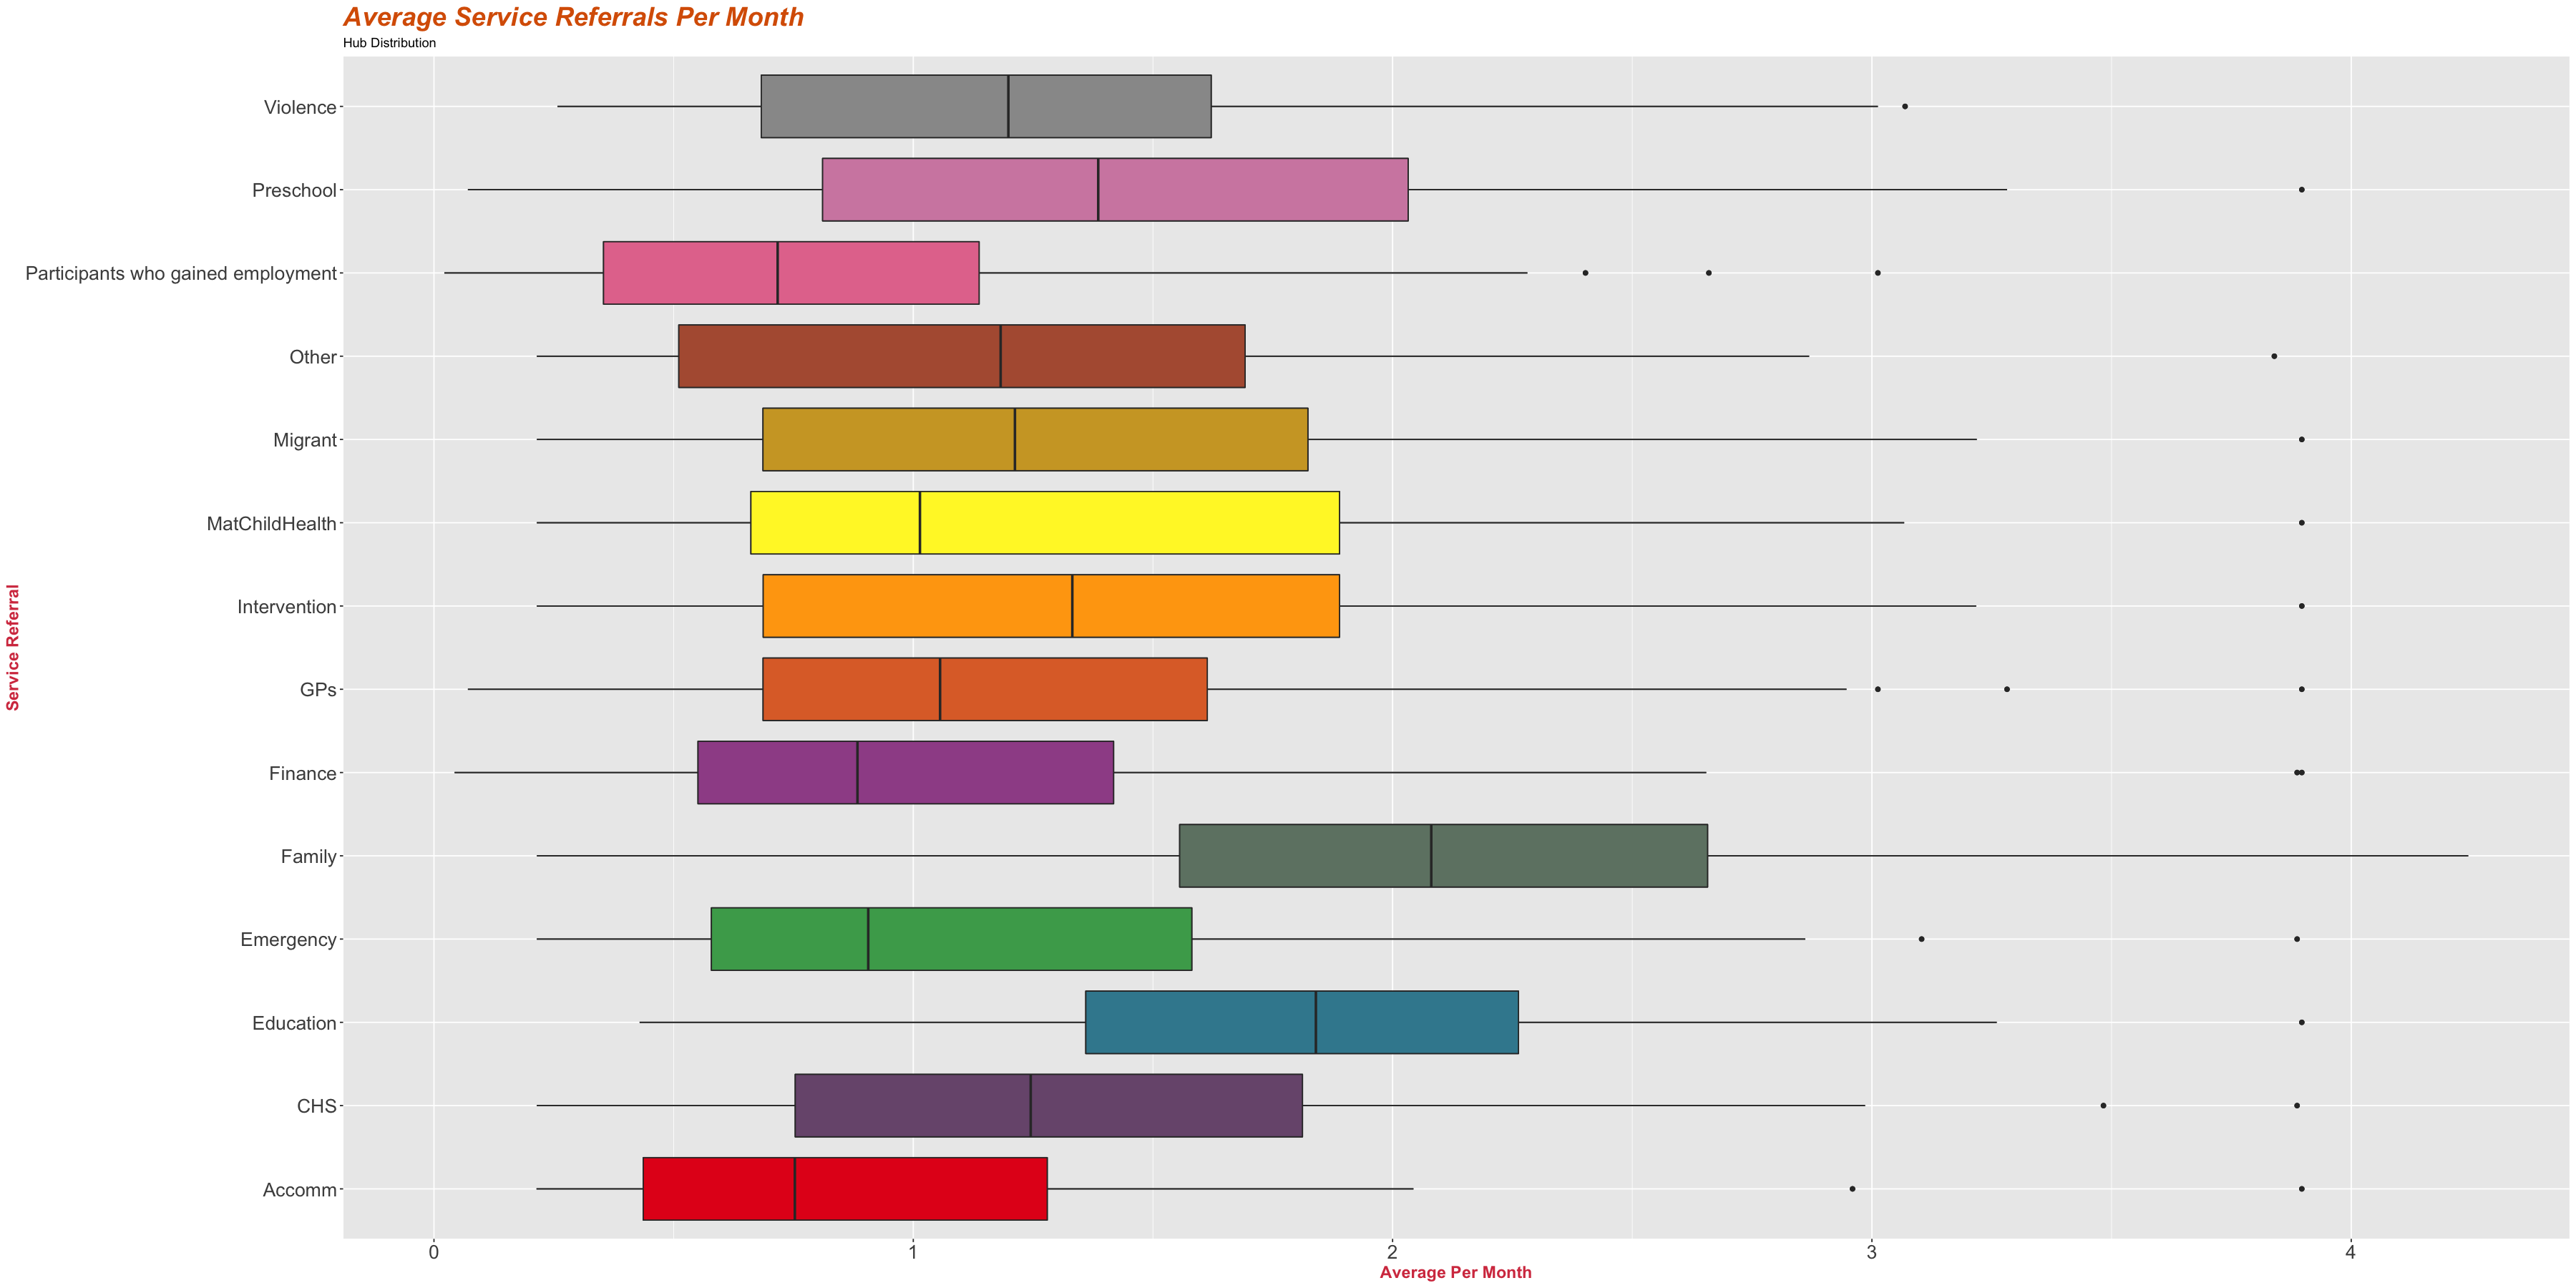

In [80]:
 colourCount = length(unique(relevant_srs $ShortName))
    getPalette = colorRampPalette(brewer.pal(9, "Set1"))    
    
        
    relevant_srs %>% ggplot(aes( x= factor(ShortName), y=avg_cnt_mnth, fill = factor(ShortName))) + 
      coord_flip()  +
      theme(legend.position = "none") +
      theme(
        # axis.title.x=element_blank(), 
        #axis.text.y=element_blank(), 
        #axis.ticks.y=element_blank(),
        legend.title =element_blank(),
        plot.title = element_text(color="#D95F02", size=22, face="bold.italic"),
        axis.title.x = element_text(color="#D53E4F", size=14, face="bold"),
        axis.title.y = element_text(color="#D53E4F", size=14, face="bold"),
        axis.text=element_text(size=16)
      ) +
      #scale_x_discrete(expand = c(0,0)) +
      #scale_y_discrete(expand = c(0,0)) +
#      scale_fill_brewer(colorRampPalette(brewer.pal(9, "Set1")), type = "div", direction = 1) +
      geom_boxplot(alpha =1)  +
      xlab("Service Referral") +
      ylab("Average Per Month") +
      ggtitle("Average Service Referrals Per Month", subtitle = "Hub Distribution") +
      theme(axis.title=element_text(size=12,face="bold"),
            axis.text=element_text(size=16),
      ) +
      #theme(axis.title.x=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
      geom_boxplot(fill=getPalette(colourCount))

options(repr.plot.width=30, repr.plot.height=15)

#### Slide 13: Alternate Plot

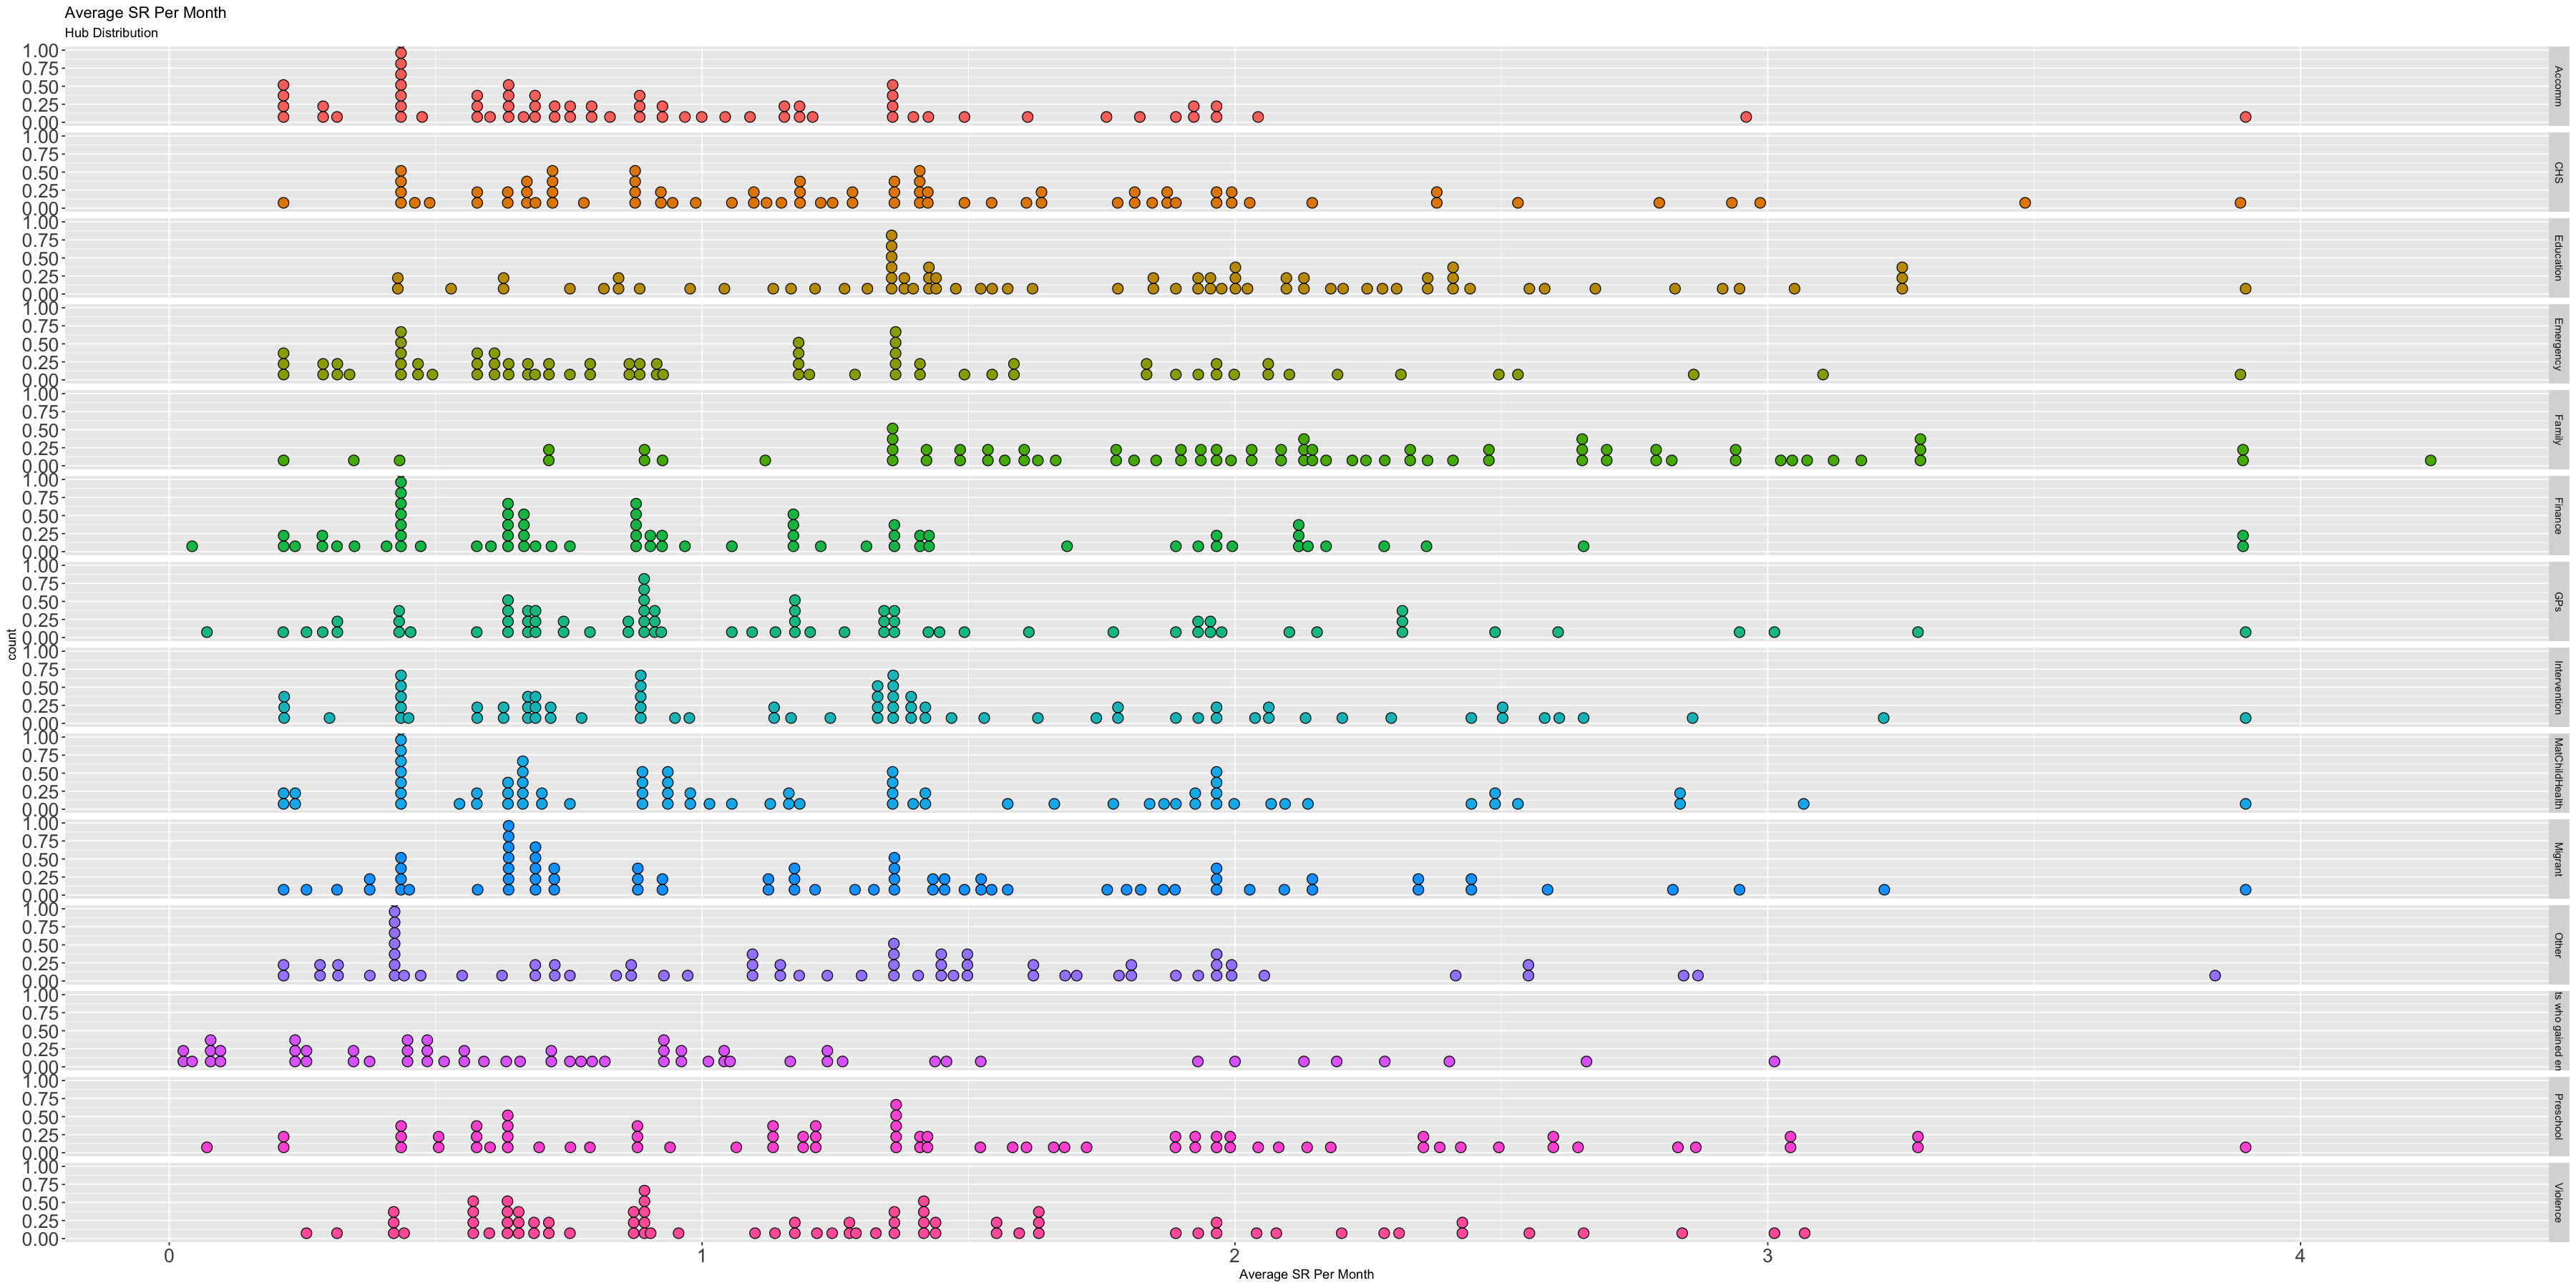

In [81]:
relevant_srs  %>% 
ggplot(aes(x=avg_cnt_mnth)) +
xlab("Average SR Per Month") +
ggtitle("Average SR Per Month", subtitle = "Hub Distribution")+
geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.02, aes(fill =factor(ShortName)) )+
facet_grid(rows = vars(ShortName)) +
theme(legend.position = "none",
     axis.text=element_text(size=16),
     ) 
options(repr.plot.width=30, repr.plot.height=15)

#### Slide 13: SRs of Each Type on Average Per Month (Stats):

In [316]:
relevant_srs_stats<-  relevant_srs %>% group_by(ShortName) %>% summarise(min = min(avg_cnt_mnth),
                          q1 = quantile(avg_cnt_mnth,0.25),
                          mean = mean(avg_cnt_mnth),
                          median = median(avg_cnt_mnth),
                          q3 = quantile(avg_cnt_mnth,0.75),
                          max = max(avg_cnt_mnth),
                          sd = sd(avg_cnt_mnth),
                          IQR = IQR(avg_cnt_mnth),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) %>% arrange(desc(mean))
relevant_srs_stats

ShortName                          min        q1        mean      median   
1  Family                             0.21465538 1.5557554 2.0883624 2.0806888
2  Education                          0.42900799 1.3599136 1.7930441 1.8399496
3  Preschool                          0.07073643 0.8108164 1.5178536 1.3858557
4  CHS                                0.21450400 0.7537072 1.3584839 1.2450012
5  Intervention                       0.21450400 0.6868972 1.3446138 1.3318032
6  Migrant                            0.21465538 0.6864128 1.3123328 1.2120493
7  Violence                           0.25758645 0.6828853 1.2736208 1.1983694
8  MatChildHealth                     0.21450400 0.6612319 1.2632484 1.0138889
9  GPs                                0.07073643 0.6866065 1.2429164 1.0558977
10 Other                              0.21450400 0.5108038 1.2295483 1.1822733
11 Emergency                          0.21450400 0.5788138 1.1607131 0.9060284
12 Finance                            0.04296139 0.5508520 1.1067074 0.8835638
13 Accomm                             0.21390061 0.4365916 0.9625175 0.7528878
14 Participants who gained employment 0.02161810 0.3537643 0.8701394 0.7170360
   q3       max      sd        IQR       latest_open_dt latest_activity_dt
1  2.657141 4.244186 0.8223856 1.1013853 2019-05-03     2019-12-20        
2  2.262571 3.896920 0.7368383 0.9026575 2019-05-03     2019-12-20        
3  2.032413 3.896920 0.8513754 1.2215961 2019-05-03     2019-12-20        
4  1.811911 3.887114 0.7406938 1.0582036 2019-05-03     2019-12-20        
5  1.889234 3.896920 0.7839284 1.2023368 2019-05-03     2019-12-20        
6  1.823284 3.896920 0.7785648 1.1368712 2019-05-03     2019-12-20        
7  1.621474 3.069255 0.6903589 0.9385886 2019-05-03     2019-12-20        
8  1.889234 3.896920 0.7889389 1.2280021 2019-05-03     2019-12-20        
9  1.613331 3.896920 0.7812028 0.9267245 2019-05-03     2019-12-20        
10 1.692246 3.839622 0.7528170 1.1814424 2019-05-03     2019-12-20        
11 1.581064 3.887114 0.7688919 1.0022505 2019-05-03     2019-12-20        
12 1.417894 3.896920 0.7921365 0.8670423 2019-05-03     2019-12-20        
13 1.279421 3.896920 0.6619131 0.8428294 2019-05-03     2019-12-20        
14 1.137289 3.012513 0.7146691 0.7835244 2019-02-04     2019-12-20        
   LowOutlier   HighOutliet
1  -0.096322545 4.309219   
2   0.005927304 3.616557   
3  -1.021577756 3.864807   
4  -0.833598174 3.399216   
5  -1.116607930 3.692739   
6  -1.018893982 3.528591   
7  -0.724997615 3.029357   
8  -1.180771222 3.731237   
9  -0.703480286 3.003418   
10 -1.261359856 3.464410   
11 -0.924561964 3.084440   
12 -0.749711551 2.718458   
13 -0.827652502 2.543665   
14 -0.821522301 2.312575

----

### Slide 14


#### Slide 14:Service Referrals Per PA (Plot)

In [82]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [83]:
Datathon$ActivityDate <- as.character(Datathon$ActivityDate)
Datathon$ActivityDate<- dmy(Datathon$ActivityDate)

### Get a long table for all SRS for all Hubs
hub_pa_agg_mth <- Datathon %>% 
                    #### Remove all Activities with 0 attendees unless they are Service Referrals:
                    filter((CategoryName != "Service Referrals" & (ChildParticipants != 0 | AdultParticipants !=0 )) | CategoryName == "Service Referrals" ) %>%
                    #### Remove all SR with 'Number of Families Participating'
                    filter(ShortName != "Number of families participating in the Hub" &
                           ShortName != 'Children'&
                           ShortName != 'Adults' 
                          ) %>% 
                    group_by(HubRandomID, CategoryName ) %>%
                    summarise(cnt = n())

# get min and max dates for each hub and join back to table
hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
                                                            max_dt = max(ActivityDate),
                                                            duration = max_dt - min_dt)

hub_pa_agg_mth <- hub_pa_agg_mth %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Join maxmin dates back to table:
hub_pa_agg_mth <- hub_pa_agg_mth %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth                      
                       )

# Create a wide table useful for analysis 
hub_pa_agg_mth_wide <-  pivot_wider(hub_pa_agg_mth ,names_from = CategoryName, values_from = c(cnt, avg_cnt_mnth), values_fill = list(cnt = 0, avg_cnt_mnth =0)) 

### Rename columns:
hub_pa_agg_mth_wide <- hub_pa_agg_mth_wide %>% rename(
                                                      cnt_EAT = "cnt_Education and Training",
                                                      cnt_OOE = "cnt_One Off events",
                                                      cnt_PA = "cnt_Programmed Activities",
                                                      cnt_SR = "cnt_Service Referrals",
                                                      
                                                      # avg_cnt_mth
                                                      avg_cnt_mth_EAT = "avg_cnt_mnth_Education and Training",
                                                      avg_cnt_mth_OOE = "avg_cnt_mnth_One Off events",
                                                      avg_cnt_mth_PA = "avg_cnt_mnth_Programmed Activities",
                                                      avg_cnt_mth_SR = "avg_cnt_mnth_Service Referrals"
                                                    ) #For renaming tibble column using dplyrpipe
                                           #operator

### Calculate create feature as proportion of month:
hub_pa_agg_mth_wide <- hub_pa_agg_mth_wide %>% mutate( total_avg_cnt_mth = avg_cnt_mth_EAT+avg_cnt_mth_OOE+avg_cnt_mth_PA+avg_cnt_mth_SR,
                                PA_avg_prop = avg_cnt_mth_PA / total_avg_cnt_mth,
                                EAT_avg_prop = avg_cnt_mth_EAT/ total_avg_cnt_mth,
                                OOE_avg_prop = avg_cnt_mth_OOE/ total_avg_cnt_mth,
                                SR_avg_prop = avg_cnt_mth_SR/ total_avg_cnt_mth,
                                SR_PA_ratio = avg_cnt_mth_SR/avg_cnt_mth_PA                        
                                                     )

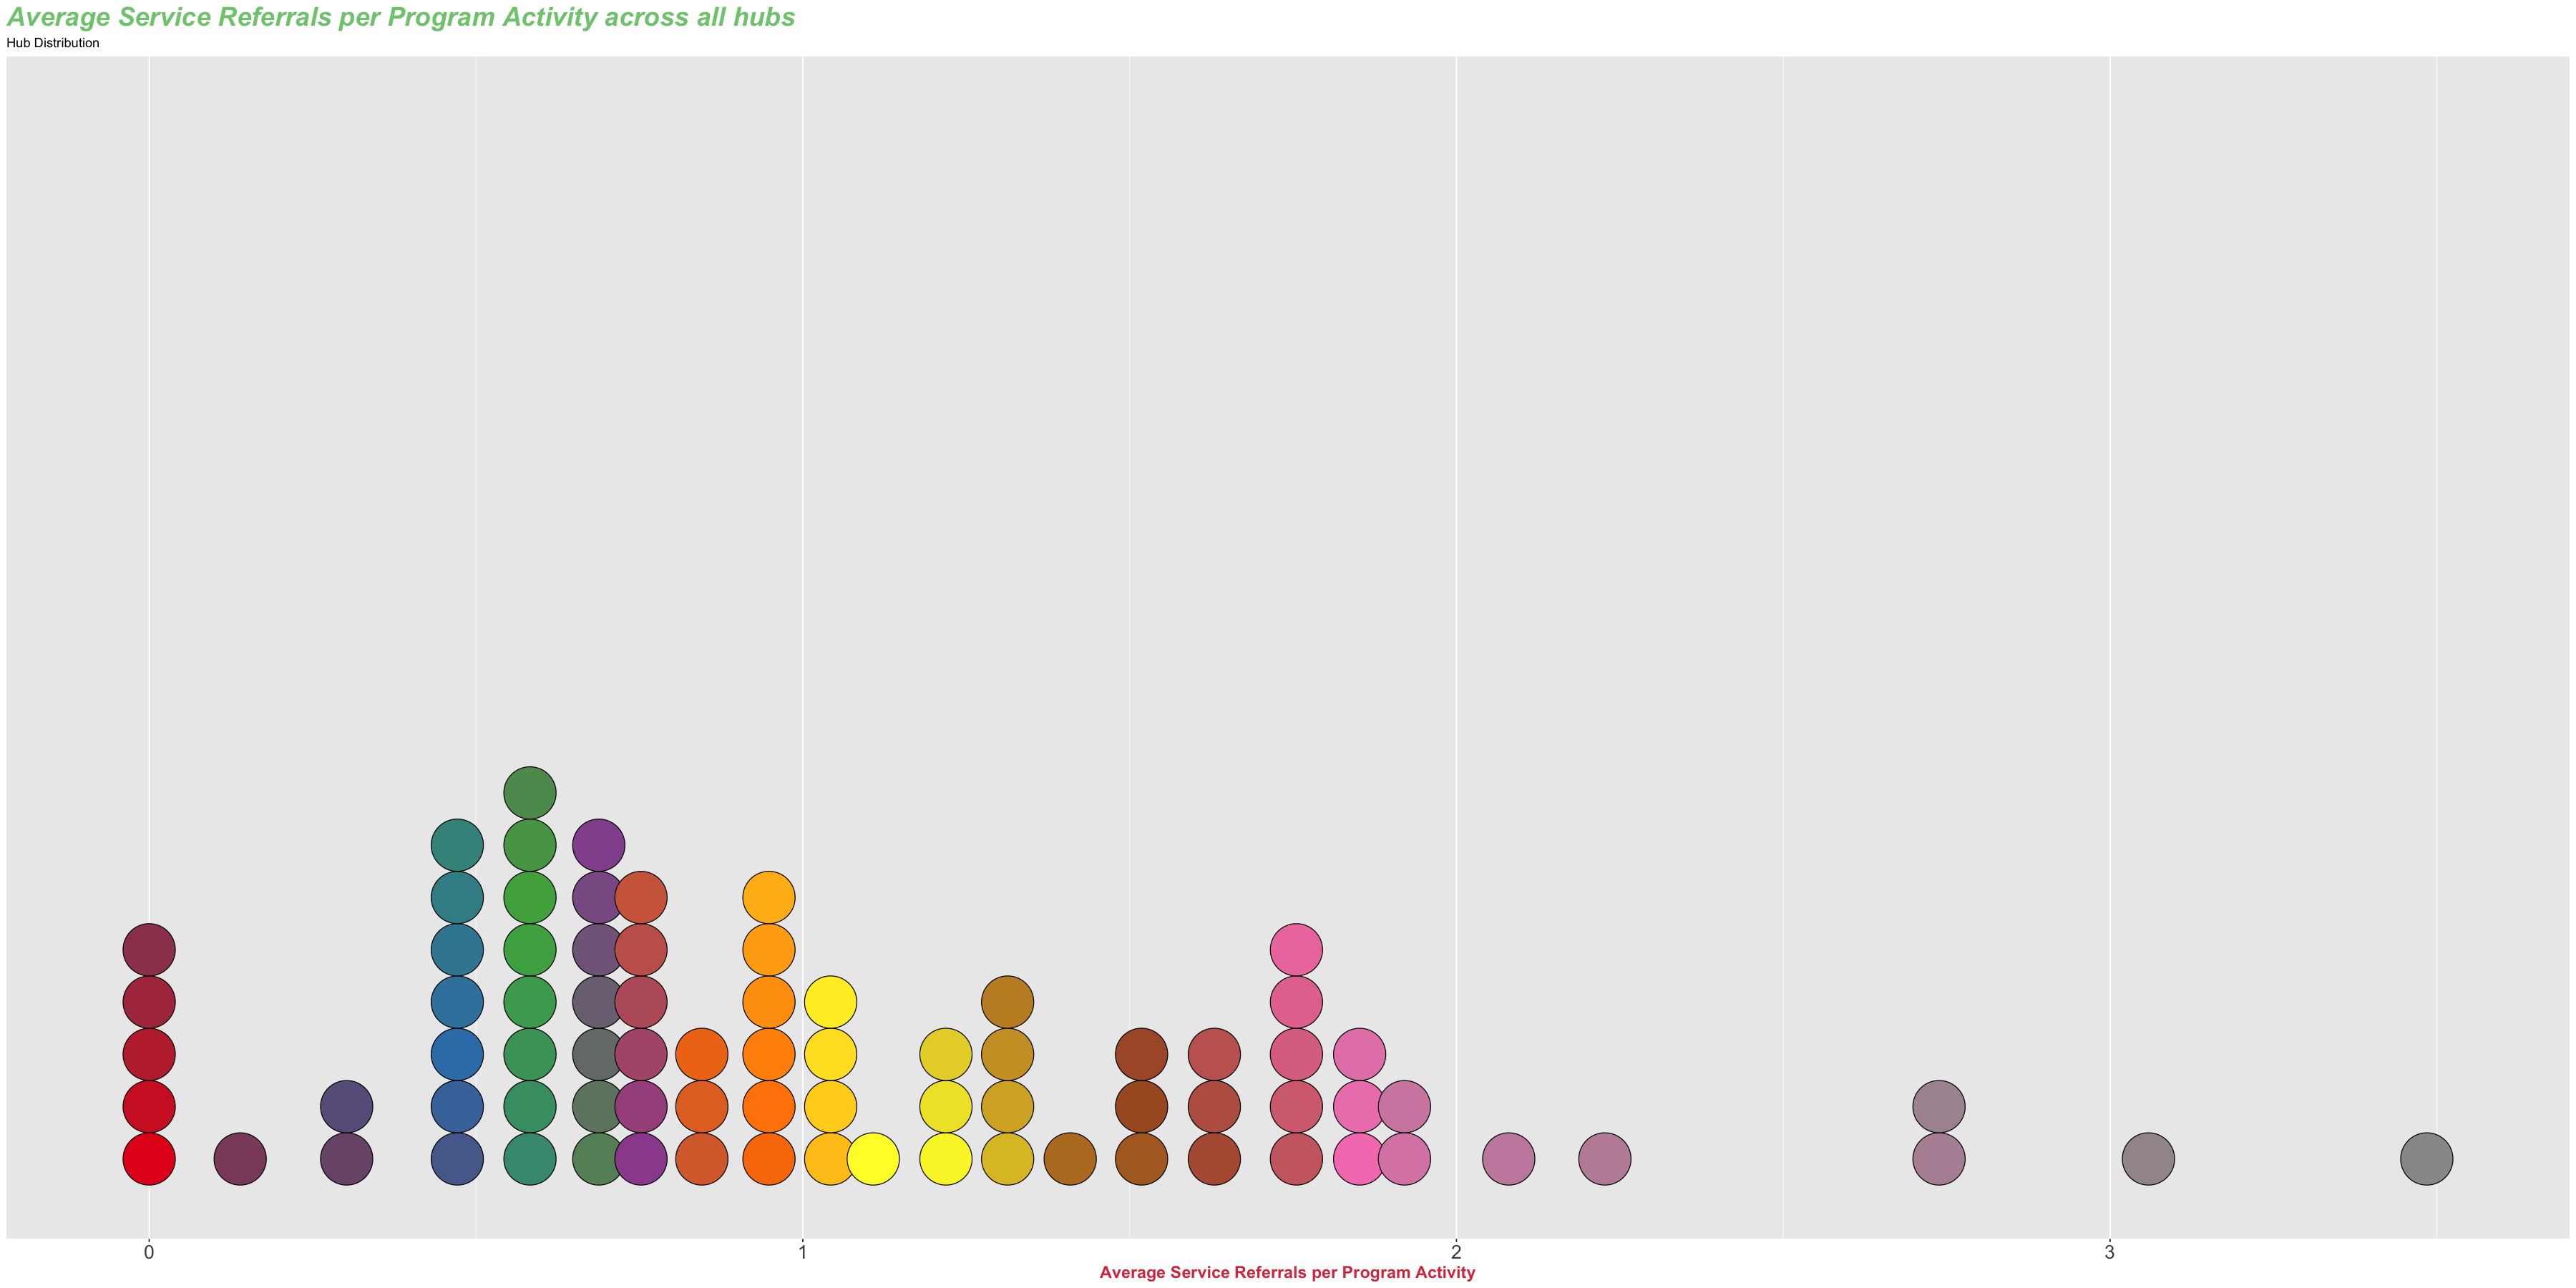

In [84]:
colourCount = length(unique(hub_pa_agg_mth_wide$HubRandomID))
hub_pa_agg_mth_wide  %>% 
      ggplot(aes(x=SR_PA_ratio)) +
      xlab("Average Service Referrals per Program Activity") +
      ylab("Proportion") +
      ggtitle("Average Service Referrals per Program Activity across all hubs", subtitle = "Hub Distribution")+
      geom_dotplot(binpositions="all",stackgroups = TRUE,binwidth = 0.08, fill=getPalette(colourCount))+
      theme(legend.position = "none",
            axis.text=element_text(size=16)
      ) +
      theme(legend.position = "none") +
      theme(
        # axis.title.x=element_blank(), 
        #axis.text.y=element_blank(), 
        #axis.ticks.y=element_blank(),
        legend.title =element_blank(),
        plot.title = element_text(color="#7FC97F", size=22, face="bold.italic"),
        axis.title.x = element_text(color="#D53E4F", size=14, face="bold"),
        axis.title.y = element_text(color="#D53E4F", size=14, face="bold"),
        axis.text=element_text(size=16)
      )+
    scale_y_continuous(NULL, breaks = NULL)
    

In [37]:
hub_pa_agg_mth_wide %>% ungroup() %>% summarise(min = min(SR_PA_ratio),
                          q1 = quantile(SR_PA_ratio,0.25),
                          mean = mean(SR_PA_ratio),
                          median = median(SR_PA_ratio),
                          q3 = quantile(SR_PA_ratio,0.75),
                          max = max(SR_PA_ratio),
                          sd = sd(SR_PA_ratio),
                          IQR = IQR(SR_PA_ratio),
                          latest_open_dt = max(min_dt),
                          latest_activity_dt = max(max_dt),
                          LowOutlier= (q1 - 1.5*IQR),
                          HighOutliet = (q3 + 1.5*IQR)
                           ) %>% arrange(desc(IQR))


min q1        mean     median    q3       max      sd        IQR      
1 0   0.5666253 1.070041 0.9160245 1.531844 3.484536 0.7082277 0.9652183
  latest_open_dt latest_activity_dt LowOutlier HighOutliet
1 2019-06-28     2019-12-20         -0.8812022 2.979671

- We can see that on average there is approximately 1.07 SR per PA run when whene excluding PAs with 0 attendees
- There are a couple outliers hubs having more than 3 SR per PA.

In [8]:
hub_pa_agg_mth_wide %>% filter (SR_PA_ratio >3) %>% select(-PA_avg_prop, -EAT_avg_prop)

HubRandomID min_dt     max_dt     duration  duration_mnth cnt_EAT cnt_OOE
1 18200       2017-01-23 2019-12-11 1052 days 34.58630        5     0      
2 18315       2016-02-01 2018-07-02  882 days 28.99726      200     0      
  cnt_PA cnt_SR avg_cnt_mth_EAT avg_cnt_mth_OOE avg_cnt_mth_PA avg_cnt_mth_SR
1 194     676   0.1445659       0                5.609157      19.54531      
2 443    1355   6.8972033       0               15.277305      46.72855      
  total_avg_cnt_mth OOE_avg_prop SR_avg_prop SR_PA_ratio
1 25.29903          0            0.7725714   3.484536   
2 68.90306          0            0.6781782   3.058691

----

### Slide 16

#### Slide 16: Hierarchical Clustering to Determine Similarities Between Hubs

In [85]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [86]:
### Get a long table for all SRS for all Hubs
hub_pa_agg <- Datathon %>% filter(CategoryName == "Programmed Activities" & (ChildParticipants != 0 | AdultParticipants !=0 )) %>% group_by(HubRandomID, ShortName ) %>% summarise(
    cnt = n(),
    cnt_child = sum(ChildParticipants),
    cnt_adult = sum(AdultParticipants),
    avg_cnt_pa = ((cnt_child + cnt_adult) / cnt), # avg attendance per session
    avg_child_pa = cnt_child/cnt, # average child attendance per session
    avg_adult_pa = cnt_adult/cnt) # average adult attendance per session

# get min and max dates for each hub and join back to table
#hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
#                                                            max_dt = max(ActivityDate),
#                                                            duration = max_dt - min_dt
#                                                           ) 
# Join maxmin dates back to table:
hub_pa_agg <- hub_pa_agg %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Develop new metrics - avg per month:
hub_pa_agg <- hub_pa_agg %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
                        avg_cnt_mnth = cnt/ duration_mnth                      
                       )
# Develop wide table with column for each SR based on avg cnt per month
hub_pa_agg_wide <- hub_pa_agg %>% select(HubRandomID, ShortName, min_dt, max_dt, duration_mnth,avg_cnt_mnth ) %>% pivot_wider(names_from = ShortName, values_from = c(avg_cnt_mnth), values_fill = list(avg_cnt_mnth = 0))   



#### Slide 16: Similarity between hubs based on average PA types run per month

In [87]:
data_clust <- hub_pa_agg_wide %>% ungroup() %>%select(-HubRandomID,-min_dt,-max_dt, -duration_mnth)  ### Columns to exclude
row.names(data_clust) <- hub_pa_agg_wide$HubRandomID  #### Row names for the HCLUST
data_clust_dist <- dist(data_clust)  #### This creates a distance matrix from each column
cluster <- hclust(data_clust_dist)   ##### This is the command to create the heirchical cluster
dend <- as.dendrogram(cluster) #### This is the function to create the dendrogram to display different style diagram
#### Several different ways to present the heirarchical diagram:
#plot(cluster, main= "Program Activity Types Per Month Similarity Clustering", cex=1, hang = -1, axes = FALSE)
#plot(dend, main= "MSO vs Condition Clustering", cex=0.9, hang = -1, axes = FALSE)
#plot(dend, hang = -1, type = "triangle")
hub_pa_agg_wide [cluster$order,]

Warning message:
“Setting row names on a tibble is deprecated.”


HubRandomID min_dt     max_dt     duration_mnth EnglishClasses Lifestyle 
1  15669       2016-01-27 2016-12-05 10.290411      0.000000      18.6581470
2  19483       2016-01-27 2019-12-05 46.290411      4.514974      16.9581558
3  10833       2016-01-27 2019-12-19 46.750685      1.326184      12.4704055
4  14082       2016-02-01 2019-12-20 46.619178      4.740538      11.5617654
5  14935       2016-02-01 2019-12-20 46.619178      5.941761      11.0255054
6  12369       2016-02-01 2019-12-20 46.619178      4.761989       9.4810766
7  14226       2016-02-01 2019-12-20 46.619178      4.654737       8.5587094
8  18922       2017-01-23 2019-12-20 34.882192      3.526155      12.2412033
9  13516       2016-01-27 2019-12-11 46.487671      3.871994       7.8085219
10 16512       2019-05-03 2019-12-12  7.331507      2.045964       7.9110613
11 13590       2016-02-01 2019-12-20 46.619178      3.861072       7.2716855
12 11227       2016-02-01 2019-12-18 46.553425      5.821269       4.8761182
13 16912       2017-10-02 2019-12-20 26.597260      3.797384       4.6621343
14 18154       2016-02-01 2019-12-13 46.389041      4.742499       7.7820104
15 19277       2016-02-01 2019-12-16 46.487671      6.410302       5.4638142
16 12394       2017-07-10 2019-12-20 29.358904      3.678611      10.1161814
17 17534       2016-02-01 2019-12-20 46.619178      5.555654       8.4085567
18 18335       2016-02-01 2019-12-20 46.619178      3.861072       7.4218383
19 11833       2018-10-15 2019-12-19 14.136986      6.012597       1.2025194
20 11332       2016-02-01 2019-12-18 46.553425      7.110111       3.8665254
21 15994       2016-02-01 2019-12-16 46.487671     10.174741       2.2801744
22 15830       2017-07-10 2019-12-13 29.128767      6.488431       1.5105342
23 17600       2018-01-29 2019-12-20 22.684932      6.347826       0.8816425
24 14915       2019-02-04 2019-12-12 10.224658      4.596731       0.0000000
25 16999       2016-02-01 2019-12-13 46.389041      5.906567       2.3065793
26 16538       2016-02-01 2019-12-18 46.553425      3.716161       3.7591219
27 11098       2016-01-27 2019-12-09 46.421918      4.696058       5.0407224
28 17182       2017-10-02 2019-12-19 26.564384      3.049196       4.9314150
29 19635       2016-02-01 2019-12-13 46.389041      3.405977       6.0143515
30 16050       2017-10-02 2019-12-19 26.564384      2.446885       1.5057756
⋮  ⋮           ⋮          ⋮          ⋮             ⋮              ⋮         
51 14819       2016-02-01 2019-12-18 46.553425     1.6754944      0.53701742
52 14989       2019-02-01 2019-12-13 10.356164     3.4761905      0.28968254
53 16964       2019-02-01 2019-12-20 10.586301     3.0227743      0.47230849
54 11662       2017-01-23 2019-12-13 34.652055     1.1254744      0.51944972
55 13958       2017-04-17 2019-12-12 31.857534     2.6053492      0.72196422
56 17604       2017-04-17 2019-12-05 31.627397     1.4228170      0.41103604
57 19616       2016-02-01 2019-12-17 46.520548     1.9776207      0.42991755
58 18764       2016-02-01 2018-12-17 34.520548     0.8111111      0.57936508
59 10011       2017-04-17 2019-12-09 31.758904     0.2204106      0.06297447
60 16724       2016-02-01 2019-04-08 38.202740     0.0000000      0.44499426
61 13748       2017-04-17 2019-12-13 31.890411     2.0068729      2.28908935
62 17184       2016-02-01 2019-12-19 46.586301     2.2324159      3.26276170
63 15857       2018-10-15 2019-12-16 14.038356     2.9205699      4.27400468
64 18506       2017-01-23 2019-12-17 34.783562     1.7824512      3.53615312
65 11419       2016-02-01 2019-12-12 46.356164     0.5608747      1.98463357
66 17416       2017-10-02 2019-12-20 26.597260     2.6694479      0.60156572
67 11491       2016-02-01 2019-12-20 46.619178     1.0510696      4.18282793
68 14457       2016-02-01 2019-12-20 46.619178     5.5556535      3.47496474
69 16407       2016-02-01 2016-12-19 10.586301     0.0000000      6.99016563
70 10813       2017-04-17 2019-12-17 32.021918     0.9056297      3.27900411

#### Export the data:

In [88]:
five_a<- hub_pa_agg_wide [cluster$order,]
write.table(five_a, "five_a.xls", sep="|")

#### Arrange the original DF in order of HCLUST similarity

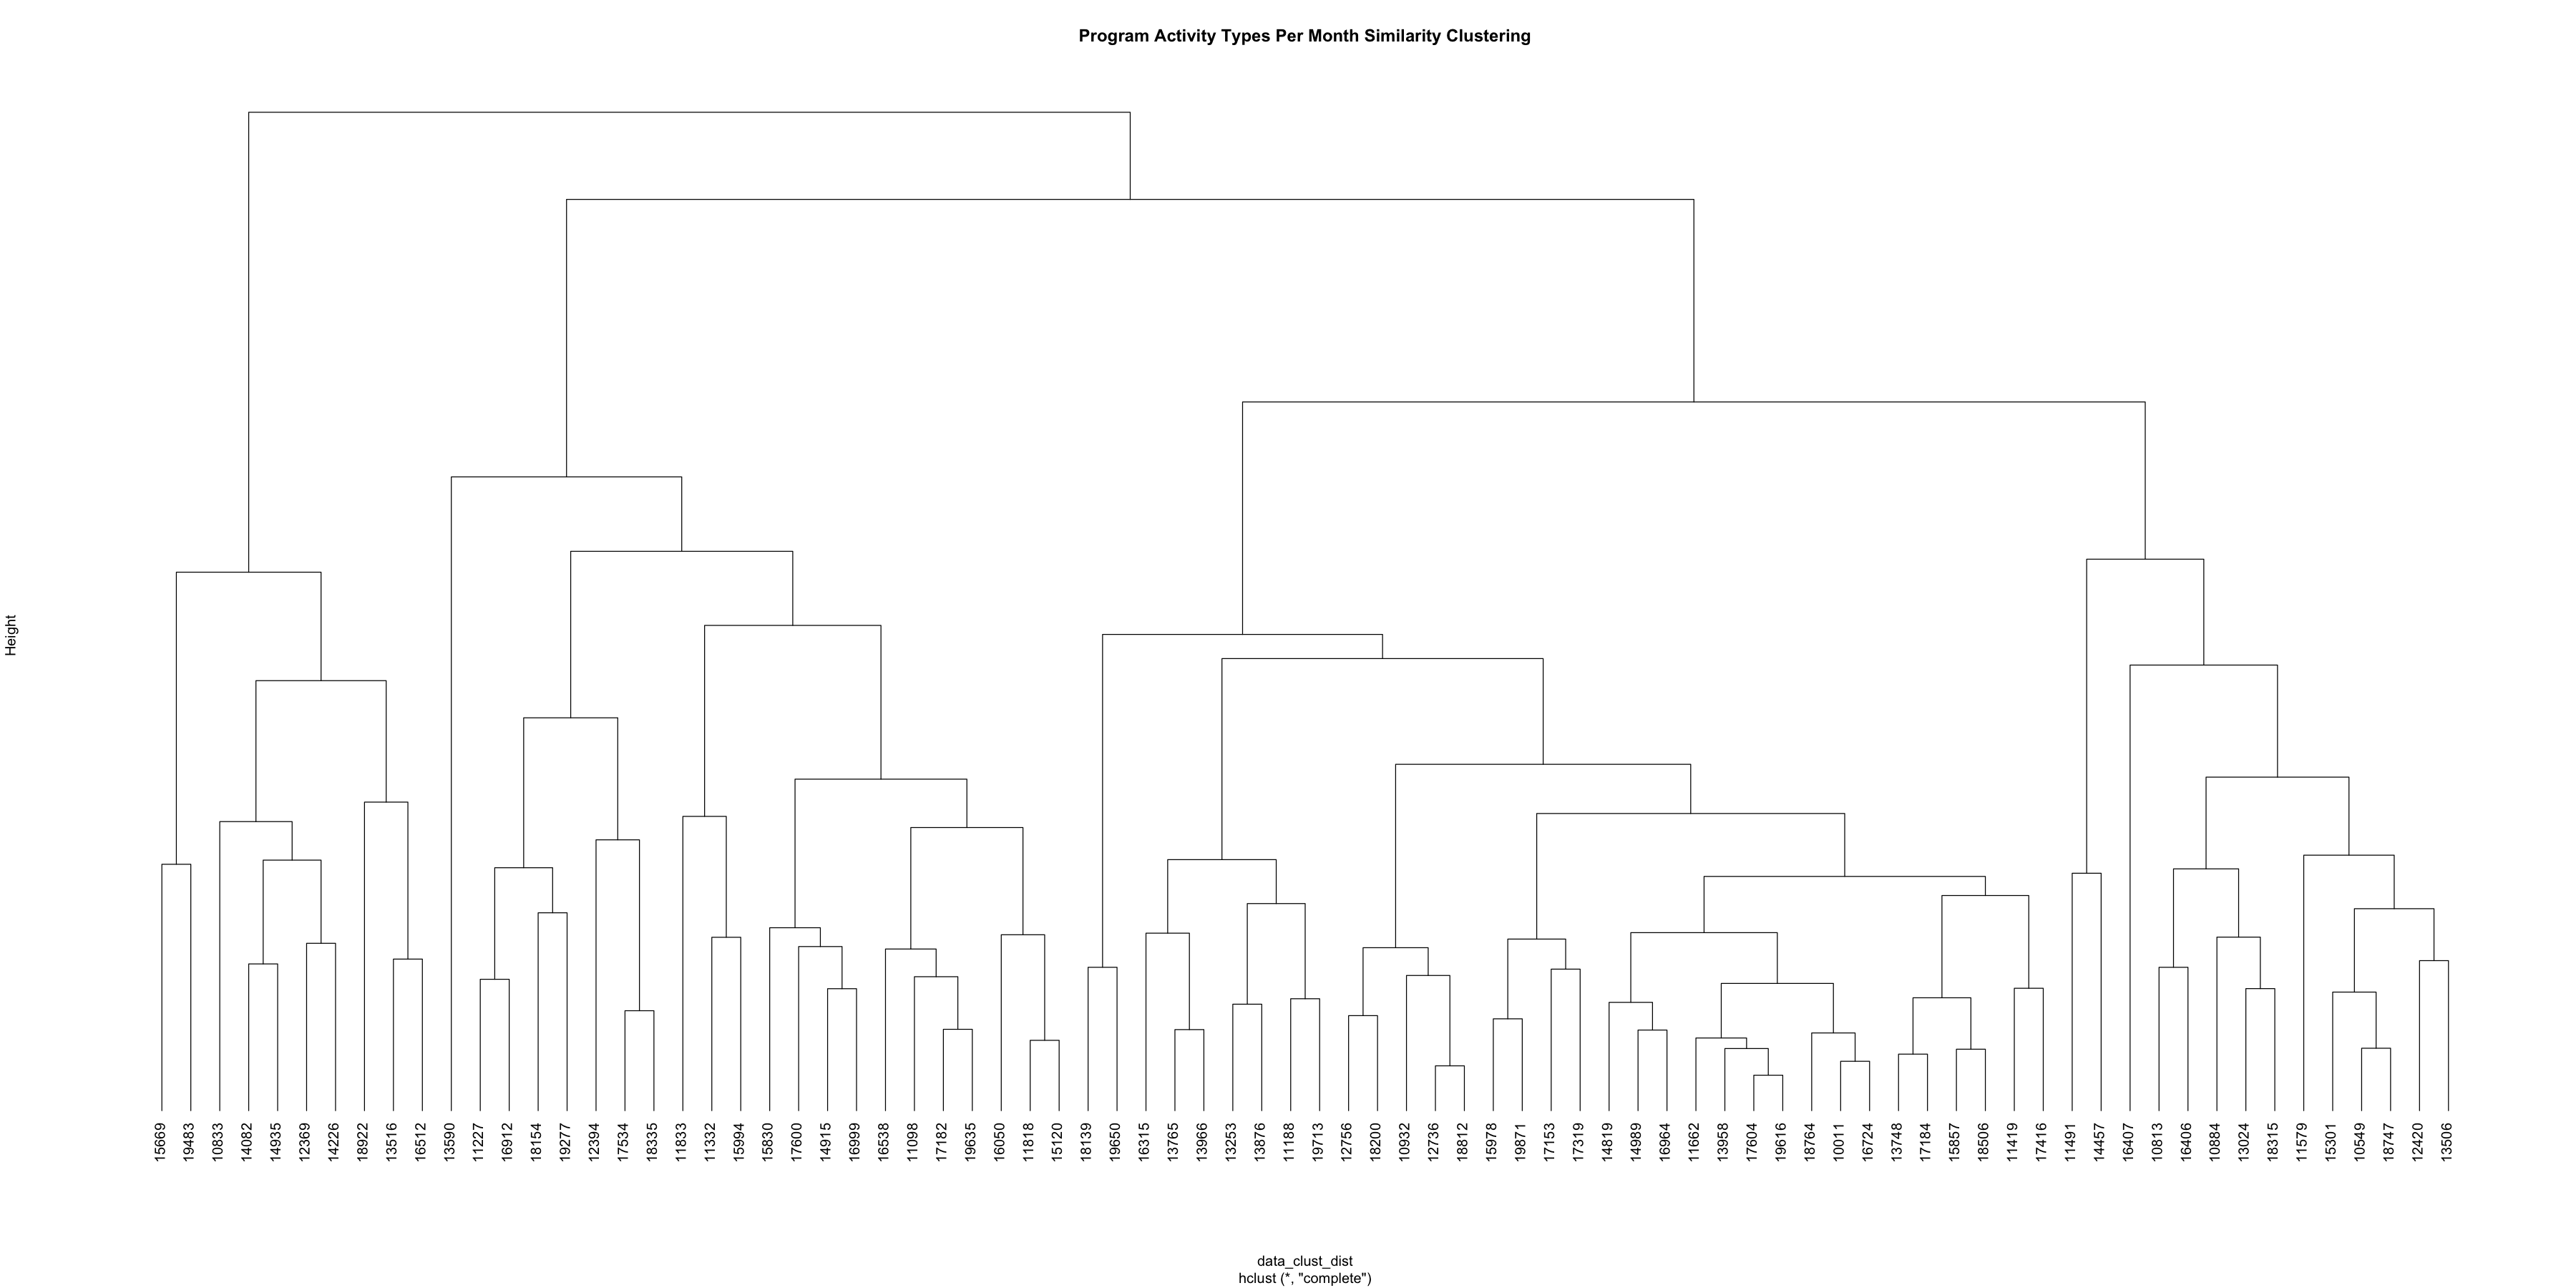

In [89]:
plot(cluster, main= "Program Activity Types Per Month Similarity Clustering", cex=1, hang = -1, axes = FALSE)

#### Slide 16B: Similarity between hubs based on average attendace per PA

In [90]:
Datathon <- read.csv("~/Google Drive/Data Science/Datathon for Social Good/datathon-social-good-master/Datathon data/Internal data track/Datathon.csv")

In [91]:
### Get a long table for all SRS for all Hubs
hub_pa_agg <- Datathon %>% filter(CategoryName == "Programmed Activities" & (ChildParticipants != 0 | AdultParticipants !=0 )) %>% group_by(HubRandomID, ShortName ) %>% summarise(
    cnt = n(),
    cnt_child = sum(ChildParticipants),
    cnt_adult = sum(AdultParticipants),
    avg_cnt_pa = ((cnt_child + cnt_adult) / cnt), # avg attendance per session
    avg_child_pa = cnt_child/cnt, # average child attendance per session
    avg_adult_pa = cnt_adult/cnt) # average adult attendance per session

# get min and max dates for each hub and join back to table
#hub_dts <- Datathon %>% group_by(HubRandomID) %>% summarise(min_dt = min(ActivityDate),
#                                                            max_dt = max(ActivityDate),
#                                                            duration = max_dt - min_dt
#                                                           ) 
# Join maxmin dates back to table:
hub_pa_agg <- hub_pa_agg %>% inner_join(hub_dts, by= c("HubRandomID" = "HubRandomID"))
# Develop new metrics - avg per month:
#hub_pa_agg <- hub_pa_agg %>% mutate(duration_mnth = as.numeric((duration/365)*12), 
#                        avg_cnt_mnth = cnt/ duration_mnth                      
#                       )
# Develop wide table with column for each SR based on avg cnt per month
hub_pa_agg_wide <- hub_pa_agg %>% select(HubRandomID, ShortName,avg_cnt_pa) %>% pivot_wider(names_from = ShortName, values_from = c(avg_cnt_pa), values_fill = list( avg_cnt_pa = 0))   


Warning message:
“Setting row names on a tibble is deprecated.”


HubRandomID EnglishClasses Lifestyle Parents   Playgroups ChildLit  
1  17604       14.400000      24.384615 27.078261 119.242424 39.631579 
2  10884        7.379310      99.769231 45.700855  37.311573 28.116959 
3  12369       13.049550      83.581448 53.184211  43.130137 34.948819 
4  10833       10.612903      52.169811 58.050251  33.702509 29.879781 
5  10813       21.103448      66.828571 74.336842  25.128755 23.068627 
6  11098       23.252294      71.803419 61.979042  28.246753 23.103627 
7  11419        5.769231      50.478261 18.772727  37.893333 35.054054 
8  19483       34.440191      57.033121 41.918728  47.761194 29.604027 
9  14935       15.823105      55.192607 38.597701  13.611111 28.700000 
10 18335        8.066667      57.170520 35.297398  14.147239  9.666667 
11 11227        9.682657      44.348018 25.111111  21.430502 15.166667 
12 13590       10.377778      45.831858 35.222222  20.855392 18.487395 
13 14082       10.144796      68.016698 12.647273  16.038005 11.301170 
14 17600       14.034722      83.700000 10.953333  21.500000 17.916667 
15 12394        8.620370      56.484848  7.797909  25.356725  0.000000 
16 13966       13.026667      48.967972 15.945813  24.957983 18.225000 
17 11579       16.322581       0.000000  0.000000  19.531915  0.000000 
18 11662        5.205128       7.722222  7.673267  22.784946  0.000000 
19 17184        3.076923       5.414474  6.043689  26.337931  0.000000 
20 10932        0.000000       0.000000  0.000000   0.000000 11.500000 
21 16315        0.000000       6.452381  6.600000   0.000000  0.000000 
22 15301        3.000000       0.000000  7.857143  11.687500  5.000000 
23 13506        6.387097       4.727273  5.866667   8.647887  0.000000 
24 15978        6.692308       2.833333  7.111111   7.625000  2.000000 
25 18139       10.807229      28.158333  7.758242  14.174603 14.294118 
26 18812       12.659091      20.000000 10.750000  14.724138 24.075000 
27 16512        3.600000      15.568966  3.315789  13.020833 10.731707 
28 16724        0.000000       8.352941  7.902439  15.026490 14.333333 
29 11818        5.535714      22.023952 18.207254  23.510791 12.842105 
30 19713        5.708955      23.882353 13.182927  23.585366 12.518519 
⋮  ⋮           ⋮              ⋮         ⋮         ⋮          ⋮         
51 18764        6.392857       21.20000 13.892562 41.20833    19.357143
52 12420        0.000000       13.00000 14.555556 28.57143    24.666667
53 15120        7.968750       18.68750 18.546632 27.74131    23.640000
54 15994       13.589852       17.11321 21.332046 22.91264    27.633333
55 11833       10.741176       18.47059 17.096774 16.52577    39.500000
56 16964       11.500000        8.40000  5.693878 17.36538    27.500000
57 15669        0.000000       38.09896 35.439394 19.70115    54.514286
58 16999       15.171533       18.47664 14.732719 24.42125    59.000000
59 13748        8.187500       35.73973 40.857143 17.45045     0.000000
60 17534       10.243243       39.89541 28.365297 17.20000     0.000000
61 18154       11.554545       32.53463  9.364929 27.68151    10.617647
62 18506       11.435484       28.47154 15.349515 20.76596     0.000000
63 14226       11.645161       32.54887 26.561644 10.83759    14.222222
64 19650       14.237037       32.97273 33.947368 17.78049    12.038462
65 13765       16.544118       28.30952 25.664234 27.15000    10.100000
66 17416       13.830986       30.43750 21.309091 21.15000    20.383562
67 11332       14.141994       24.68333 21.352332 18.84536    13.836735
68 19277       11.526846       26.98425 20.443128 24.19000    15.458333
69 16538        7.919075       38.68000 56.155063 27.87456    10.200000
70 14457       11.918919       19.48148 59.919540 18.70640    15.593952
71 16406       11.022727       22.38306 58.046632 13.03727    16.097087
72 17182        7.000000       19.95420 36.292553 34.39130    27.714286
73 18315       13.040000       12.12658 32.492308 26.05660    23.860215
74 11188       12.148810       20.38346 54.

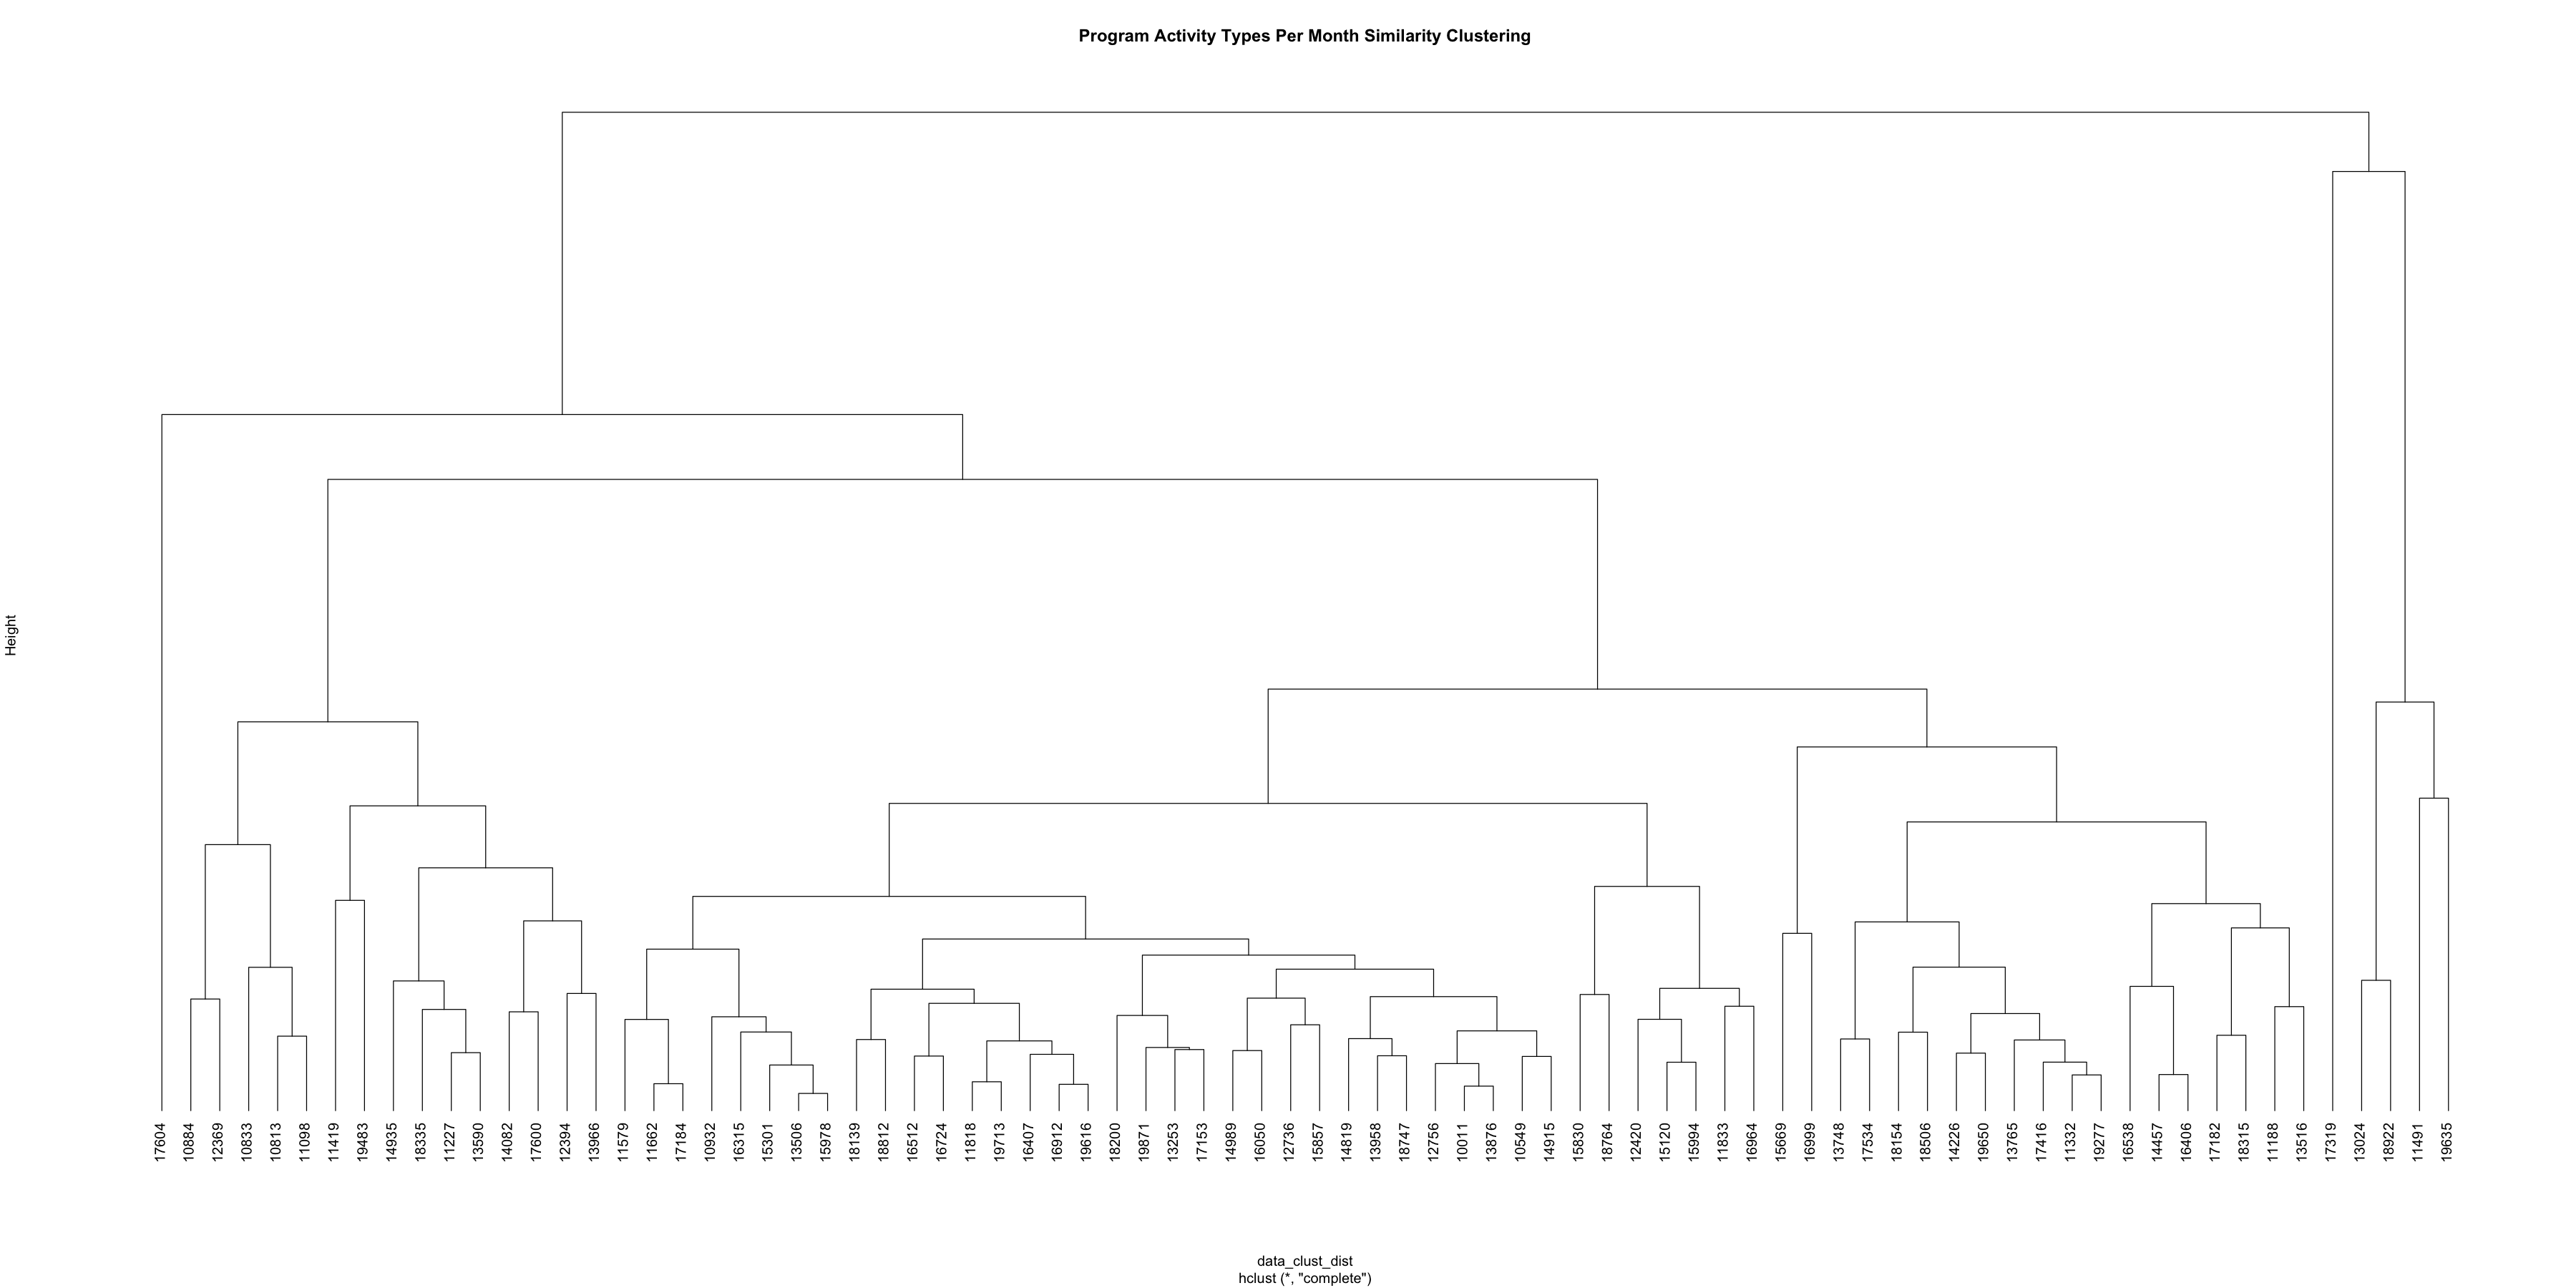

In [92]:
data_clust <- hub_pa_agg_wide %>% ungroup() %>%select(-HubRandomID)  ### Columns to exclude
row.names(data_clust) <- hub_pa_agg_wide$HubRandomID  #### Row names for the HCLUST
data_clust_dist <- dist(data_clust)  #### This creates a distance matrix from each column
cluster <- hclust(data_clust_dist)   ##### This is the command to create the heirchical cluster
dend <- as.dendrogram(cluster) #### This is the function to create the dendrogram to display different style diagram
#### Several different ways to present the heirarchical diagram:
plot(cluster, main= "Program Activity Types Per Month Similarity Clustering", cex=1, hang = -1, axes = FALSE)
#plot(dend, main= "MSO vs Condition Clustering", cex=0.9, hang = -1, axes = FALSE)
#plot(dend, hang = -1, type = "triangle")
hub_pa_agg_wide [cluster$order,]

#### Export the data:

In [93]:
five_b<- hub_pa_agg_wide [cluster$order,]
#write.table(five_b, "five_b.xls", sep="|")